In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import os
import torch
from torch.utils.data import Dataset, DataLoader
import mne
from torcheeg.transforms import BandSignal
file_path = [
            "./韩光/静息闭眼/hg_Middle_Close_2.csv",
            "./韩光/静息睁眼/hg_Middle_Open_2.csv",
            "./韩光/任务态/hg_Middle_MI_Round2_2.csv"
]

# 设定滤波参数
lowcut, highcut = 8, 40  # 设定滤波范围
fs = 250  # 采样率，需根据数据实际情况修改
window_size = 500
t = BandSignal(sampling_rate=250,band_dict={'frequency_range':[8,40]})


# 自定义 PyTorch 数据集
class EEGDataset(Dataset):
    def __init__(self, data, labels):
        self.data = torch.tensor(data, dtype=torch.float32)  # 转换为 PyTorch 张量
        self.labels = torch.tensor(labels, dtype=torch.long) # 转换为 PyTorch 张量
    
    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        return self.data[idx], self.labels[idx]


# 读取 CSV 文件
for i in range(len(file_path)):
    df = pd.read_csv(file_path[i])
    baseline = df.iloc[:500,:-2]
    baseline = baseline.values  # 转换为 NumPy 数组
    eeg_signal = df.iloc[500:, :-2]
    eeg_signal = eeg_signal.to_numpy()

    # 计算可划分的完整切片数
    num_windows = eeg_signal.shape[0] // window_size
    # 将数据按时间维度切割
    eeg_slices = eeg_signal[:num_windows * window_size].reshape(num_windows, window_size, -1)

    
    baseline = torch.tensor(baseline, dtype=torch.float32, device="cuda")
    eeg_slices = torch.tensor(eeg_slices, dtype=torch.float32, device="cuda")

    # 直接广播相减
    eeg_slices = eeg_slices - baseline.unsqueeze(0)  # 形状仍为 (305, 500, 32)
    
    eeg_slices = eeg_slices.cpu().numpy().astype(np.float64)
    print(eeg_slices.shape)
    # 进行滤波
    for k in range(len(eeg_slices)):
        eeg_slices[k] = t(eeg=eeg_slices[k])['eeg']
    print(eeg_slices.shape)

    # 转换回 PyTorch Tensor 并移动到 GPU
    eeg_slices = torch.tensor(eeg_slices, dtype=torch.float32, device="cuda")


    labels = np.full((eeg_slices.shape[0],), i, dtype=np.int64)
    labels = torch.tensor(labels, dtype=torch.long)

    file_name = os.path.basename(file_path[i])
    file_name = os.path.splitext(file_name)[0]
    # 保存为 .pt 文件
    torch.save({'data': eeg_slices, 'labels': labels}, f'./HanGuang/{file_name}_dataset.pt')
    print('done', i)


In [1]:
import torch

# 文件路径
file_paths = [
    "./HanGuang/hg_Middle_Close_2_dataset.pt",
    "./HanGuang/hg_Middle_MI_Round2_2_dataset.pt",
    "./HanGuang/hg_Middle_Open_2_dataset.pt"
]

# 用于存储所有数据
all_data = []
all_labels = []

# 逐个加载并合并
for file_path in file_paths:
    dataset = torch.load(file_path)
    eeg = dataset['data'].permute(0,2,1).unsqueeze(1)
    eeg = (eeg - eeg.mean(axis=3, keepdims=True)) / eeg.std(axis=3, keepdims=True)
    all_data.append(eeg)  # EEG 数据
    all_labels.append(dataset['labels'])  # 标签

# 拼接成一个大数据集
eeg_data = torch.cat(all_data, dim=0)  # 拼接 EEG 数据
eeg_labels = torch.cat(all_labels, dim=0)  # 拼接标签

print(f"最终数据形状: {eeg_data.shape}, 标签形状: {eeg_labels.shape}")

/root/autodl-tmp/conda/envs/law/lib/python3.8/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


最终数据形状: torch.Size([1034, 1, 32, 500]), 标签形状: torch.Size([1034])


In [ ]:
print(eeg_data[300][0].shape)


In [ ]:
sample = eeg_data[100][0].cpu().numpy()
# sample = (sample - sample.mean(axis=1, keepdims=True)) / sample.std(axis=1, keepdims=True)

time = np.arange(sample.shape[1])  # 500 个时间点
num_channels = sample.shape[0]  # 32 个通道

# 创建子图
fig, axes = plt.subplots(num_channels, 1, figsize=(10, 1.5 * num_channels), sharex=True)

for i in range(num_channels):
    axes[i].plot(time, sample[i, :], label=f'Electrode {i+1}')
    axes[i].set_ylabel('Amplitude')
    axes[i].legend(loc='upper right')

axes[-1].set_xlabel('Time')  # 仅在最后一个子图设置 X 轴标签
fig.suptitle(f'EEG Signals from sample 300', fontsize=16)
plt.tight_layout(rect=[0, 0, 1, 0.97])  # 调整布局
plt.show()


In [15]:
from torch.utils.data import TensorDataset, DataLoader

# 创建数据集
dataset = TensorDataset(eeg_data, eeg_labels)

# 创建 DataLoader
dataloader = DataLoader(dataset, batch_size=16, shuffle=True)


# 训练时迭代数据
for batch in dataloader:
    x,y = batch
    x = x.squeeze(1)
    x_np = x.cpu().numpy()
    # print(x.shape,y)
    data = list(x_np)
    # print(data[0].shape)
    labels = y.tolist()
    # print(label)
    break  # 只打印一次 batch

In [16]:
print(labels)

[1, 0, 1, 1, 1, 0, 2, 1, 0, 0, 1, 1, 2, 2, 2, 2]


In [17]:
# 选取 3 个不同 label 的数据
selected_data = []
selected_labels = []
unique_labels = set()

for i, label in enumerate(labels):
    if label not in unique_labels:
        selected_data.append(data[i])  # 选中第一个该标签的数据
        selected_labels.append(label)
        unique_labels.add(label)  # 记录已选择的标签
    if len(unique_labels) == 3:  # 只取 3 个不同的 label
        break

# 检查结果
print(f"选取了 {len(selected_data)} 个不同 label 的 EEG 样本")
for i, (d, lbl) in enumerate(zip(selected_data, selected_labels)):
    print(f"Sample {i}: Label={lbl}, Shape={d.shape}")

选取了 3 个不同 label 的 EEG 样本
Sample 0: Label=1, Shape=(32, 500)
Sample 1: Label=0, Shape=(32, 500)
Sample 2: Label=2, Shape=(32, 500)


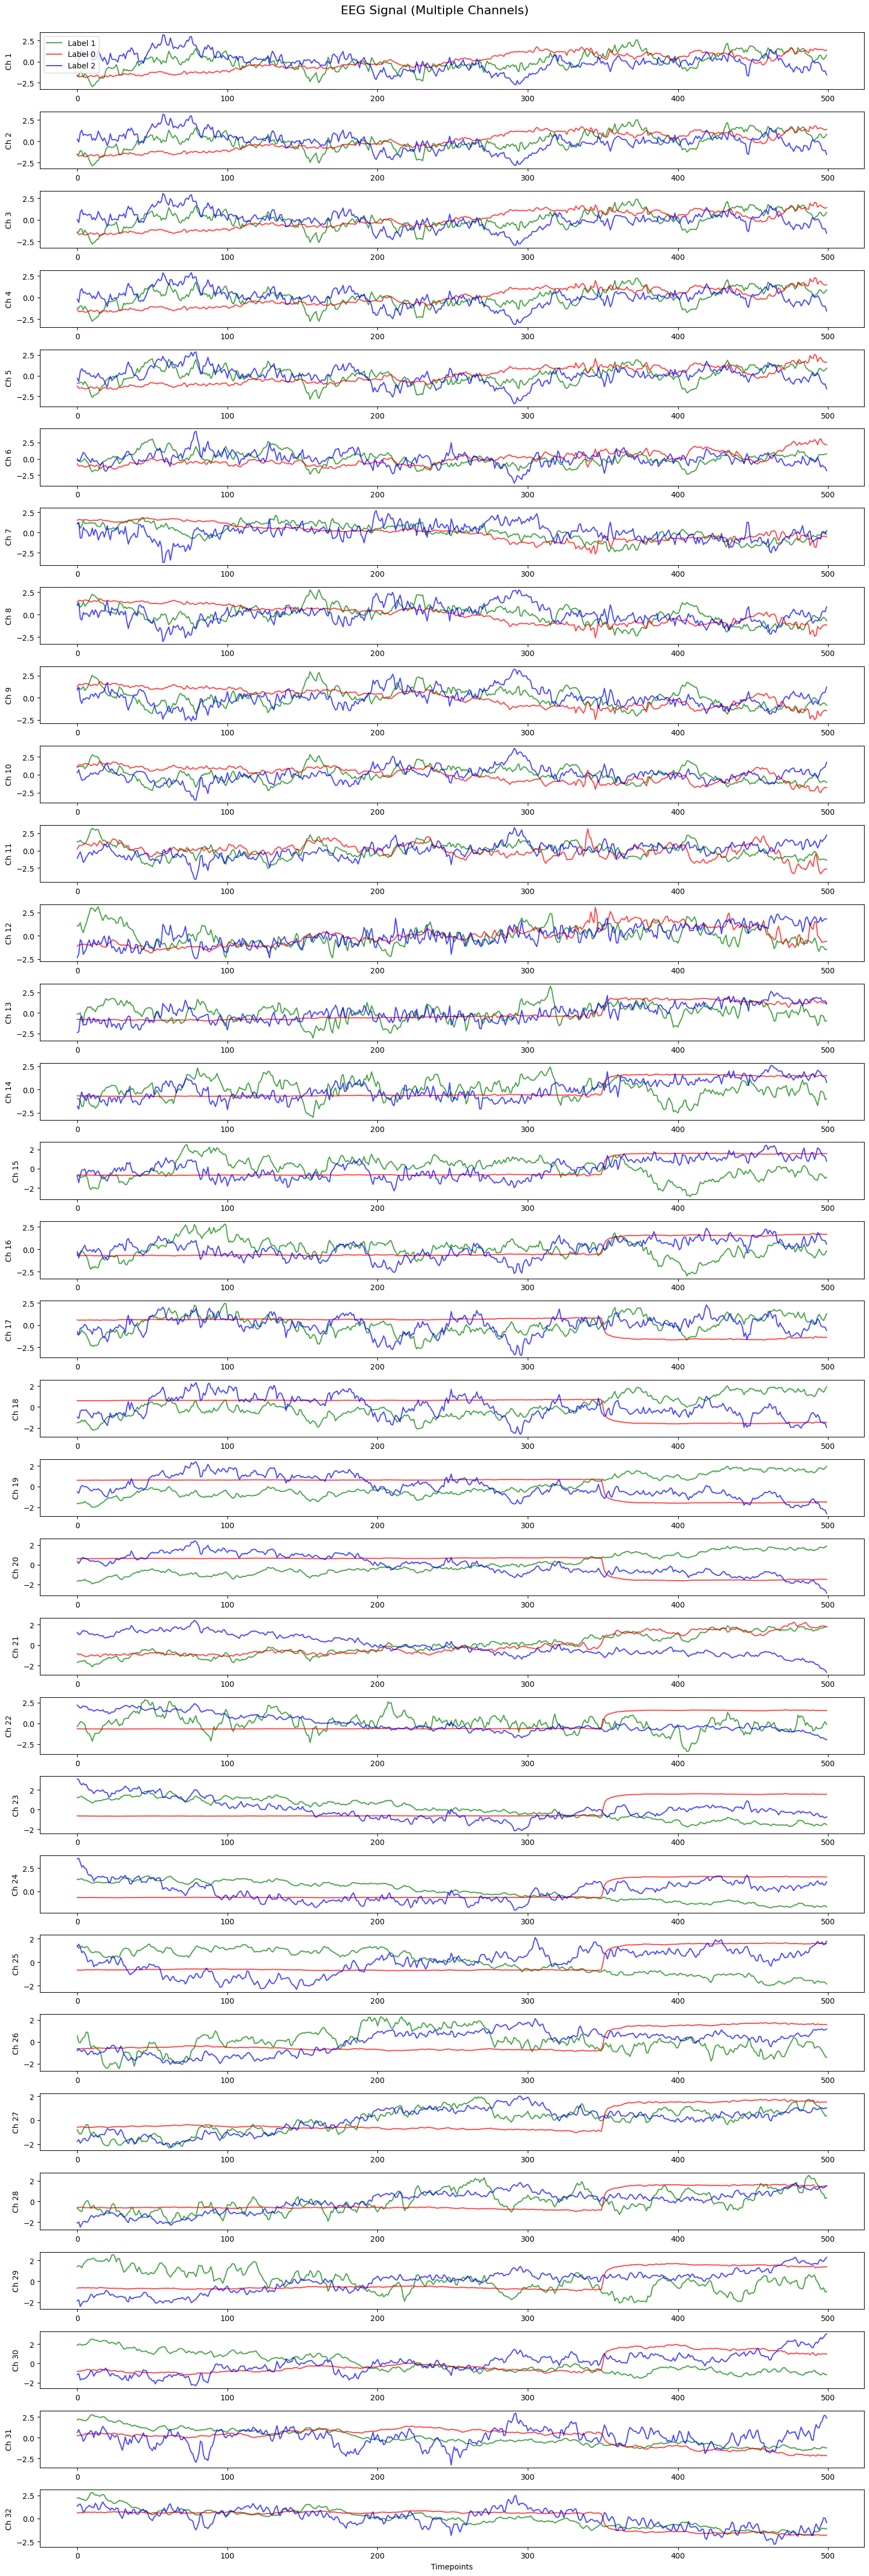

In [18]:
import matplotlib.pyplot as plt

# 定义颜色（不同 label 用不同颜色）
colors = ['r', 'g', 'b']  # 0: 红色, 1: 绿色, 2: 蓝色

# 选择要绘制的样本数
num_samples_to_plot = 3  # 画 3 个样本
num_channels = 32  # 只画前 5 个通道
plt.figure(figsize=(16, 48))

for ch in range(num_channels):
    plt.subplot(num_channels, 1, ch + 1)
    for i in range(num_samples_to_plot):
        eeg_sample = selected_data[i]
        label = selected_labels[i]
        color = colors[label]
        plt.plot(eeg_sample[ch], color=color, alpha=0.7, label=f"Label {label}" if ch == 0 else "")

    plt.ylabel(f"Ch {ch+1}")
    if ch == 0:
        plt.legend()

plt.xlabel("Timepoints")
plt.suptitle("EEG Signal (Multiple Channels)", fontsize=16)
plt.tight_layout(rect=[0, 0, 1, 0.98])  # 让 suptitle 靠近子图
plt.show()


torch.Size([16, 32, 500]) torch.Size([16])


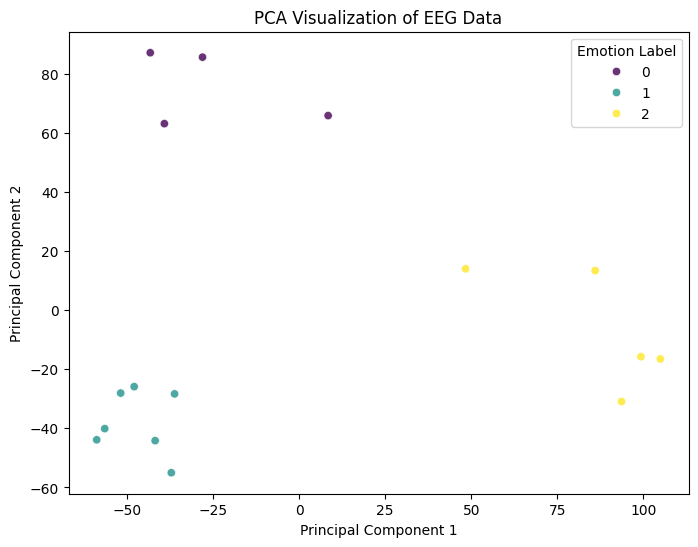

In [19]:
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
import seaborn as sns

print(x.shape,y.shape)
eeg = x.cpu().numpy()
labels = y.cpu().numpy()
# **步骤 1: 展平数据** (samples, channels*timepoints)
flattened_eeg = eeg.reshape(16, -1)  # (100, 32*500)

# **步骤 2: 进行 PCA 降维**
pca = PCA(n_components=2)
eeg_pca = pca.fit_transform(flattened_eeg)  # (100, 2)

# **步骤 3: 可视化**
plt.figure(figsize=(8, 6))
sns.scatterplot(x=eeg_pca[:, 0], y=eeg_pca[:, 1], hue=labels, palette="viridis", alpha=0.8)

plt.xlabel("Principal Component 1")
plt.ylabel("Principal Component 2")
plt.title("PCA Visualization of EEG Data")
plt.legend(title="Emotion Label")
plt.show()

In [13]:
import torch
from torch.utils.data import Subset, DataLoader
from sklearn.model_selection import KFold
from classifier import ClassifierTrainer
from torcheeg.models import ATCNet


# ✅ 2. 交叉验证配置 (4 折)
k_fold = KFold(n_splits=5, shuffle=True, random_state=42)

# ✅ 3. 训练参数
HYPERPARAMETERS = {
    "batch_size": 32,
    "lr": 1e-4,
    "weight_decay": 1e-4,
    "num_epochs": 50,
}

training_metrics, test_metrics = [], []

# ✅ 4. 交叉验证训练
for fold, (train_idx, val_idx) in enumerate(k_fold.split(dataset)):
    print(f"\n🚀 训练第 {fold+1} 折...")

    train_subset = Subset(dataset, train_idx)
    val_subset = Subset(dataset, val_idx)

    train_loader = DataLoader(train_subset, batch_size=32, shuffle=True)
    val_loader = DataLoader(val_subset, batch_size=32, shuffle=False)

    # 🎯 ATCNet 模型
    model = ATCNet(in_channels=1,
                    num_classes=3,
                    num_windows=3,
                    num_electrodes=32,
                    chunk_size=500)

    # 🎯 训练器
    trainer = ClassifierTrainer(
        model=model,
        num_classes=3,
        lr=HYPERPARAMETERS['lr'],
        weight_decay=HYPERPARAMETERS['weight_decay'],
        metrics=["accuracy"],
        accelerator="gpu"
    )

    # 🎯 训练模型
    trainer.fit(train_loader, val_loader, max_epochs=HYPERPARAMETERS['num_epochs'])

    # 🎯 计算训练 & 测试准确率
    training_result = trainer.test(train_loader)[0]
    test_result = trainer.test(val_loader)[0]

    # 🎯 记录结果
    training_metrics.append(training_result["test_accuracy"])
    test_metrics.append(test_result["test_accuracy"])

# ✅ 5. 输出最终结果
print("\n📊 训练准确率:", training_metrics)
print("📊 测试准确率:", test_metrics)
print("🔥 交叉验证平均测试准确率:", sum(test_metrics) / len(test_metrics))

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name          | Type             | Params
---------------------------------------------------
0 | model         | ATCNet           | 67.2 K
1 | ce_fn         | CrossEntropyLoss | 0     
2 | train_loss    | MeanMetric       | 0     
3 | val_loss      | MeanMetric       | 0     
4 | test_loss     | MeanMetric       | 0     
5 | train_metrics | MetricCollection | 0     
6 | val_metrics   | MetricCollection | 0     
7 | test_metrics  | MetricCollection | 0     
---------------------------------------------------
67.2 K    Trainable params
0         Non-trainable params
67.2 K    Total params
0.269     Total estimated model params size (MB)



🚀 训练第 1 折...
Sanity Checking DataLoader 0: 100%|██████████| 2/2 [00:00<00:00, 194.60it/s]

[2025-04-01 14:52:17] INFO (torcheeg/MainThread) 
[Val] val_loss: 1.087 val_accuracy: 0.734 



Epoch 0:  15%|█▌        | 5/33 [00:00<00:00, 61.88it/s, loss=1.06, train_loss=1.060, train_accuracy=0.500]

Epoch 0: 100%|██████████| 33/33 [00:00<00:00, 71.54it/s, loss=0.922, train_loss=0.758, train_accuracy=1.000]

[2025-04-01 14:52:18] INFO (torcheeg/MainThread) 
[Val] val_loss: 0.826 val_accuracy: 0.961 



Epoch 0: 100%|██████████| 33/33 [00:00<00:00, 70.84it/s, loss=0.922, train_loss=0.758, train_accuracy=1.000]

[2025-04-01 14:52:18] INFO (torcheeg/MainThread) 
[Train] train_loss: 0.952 train_accuracy: 0.750 



Epoch 1: 100%|██████████| 33/33 [00:00<00:00, 73.60it/s, loss=0.737, train_loss=0.701, train_accuracy=1.000]

[2025-04-01 14:52:18] INFO (torcheeg/MainThread) 
[Val] val_loss: 0.652 val_accuracy: 0.990 



Epoch 1: 100%|██████████| 33/33 [00:00<00:00, 72.91it/s, loss=0.737, train_loss=0.701, train_accuracy=1.000]

[2025-04-01 14:52:18] INFO (torcheeg/MainThread) 
[Train] train_loss: 0.752 train_accuracy: 0.960 



Epoch 2: 100%|██████████| 33/33 [00:00<00:00, 72.54it/s, loss=0.655, train_loss=0.621, train_accuracy=1.000]

[2025-04-01 14:52:19] INFO (torcheeg/MainThread) 
[Val] val_loss: 0.610 val_accuracy: 0.990 



Epoch 2: 100%|██████████| 33/33 [00:00<00:00, 71.87it/s, loss=0.655, train_loss=0.621, train_accuracy=1.000]

[2025-04-01 14:52:19] INFO (torcheeg/MainThread) 
[Train] train_loss: 0.663 train_accuracy: 0.983 



Epoch 3: 100%|██████████| 33/33 [00:00<00:00, 73.78it/s, loss=0.624, train_loss=0.627, train_accuracy=1.000]

[2025-04-01 14:52:19] INFO (torcheeg/MainThread) 
[Val] val_loss: 0.593 val_accuracy: 0.990 



Epoch 3: 100%|██████████| 33/33 [00:00<00:00, 73.08it/s, loss=0.624, train_loss=0.627, train_accuracy=1.000]

[2025-04-01 14:52:19] INFO (torcheeg/MainThread) 
[Train] train_loss: 0.632 train_accuracy: 0.988 



Epoch 4: 100%|██████████| 33/33 [00:00<00:00, 71.95it/s, loss=0.611, train_loss=0.590, train_accuracy=1.000]

[2025-04-01 14:52:20] INFO (torcheeg/MainThread) 
[Val] val_loss: 0.584 val_accuracy: 0.990 



Epoch 4: 100%|██████████| 33/33 [00:00<00:00, 71.22it/s, loss=0.611, train_loss=0.590, train_accuracy=1.000]

[2025-04-01 14:52:20] INFO (torcheeg/MainThread) 
[Train] train_loss: 0.616 train_accuracy: 0.984 



Epoch 5: 100%|██████████| 33/33 [00:00<00:00, 72.36it/s, loss=0.6, train_loss=0.582, train_accuracy=1.000]  

[2025-04-01 14:52:20] INFO (torcheeg/MainThread) 
[Val] val_loss: 0.578 val_accuracy: 0.990 



Epoch 5: 100%|██████████| 33/33 [00:00<00:00, 71.67it/s, loss=0.6, train_loss=0.582, train_accuracy=1.000]

[2025-04-01 14:52:20] INFO (torcheeg/MainThread) 
[Train] train_loss: 0.602 train_accuracy: 0.989 



Epoch 6: 100%|██████████| 33/33 [00:00<00:00, 71.15it/s, loss=0.596, train_loss=0.607, train_accuracy=0.963]

[2025-04-01 14:52:21] INFO (torcheeg/MainThread) 
[Val] val_loss: 0.574 val_accuracy: 0.990 



Epoch 6: 100%|██████████| 33/33 [00:00<00:00, 70.42it/s, loss=0.596, train_loss=0.607, train_accuracy=0.963]

[2025-04-01 14:52:21] INFO (torcheeg/MainThread) 
[Train] train_loss: 0.597 train_accuracy: 0.990 



Epoch 7: 100%|██████████| 33/33 [00:00<00:00, 66.19it/s, loss=0.589, train_loss=0.566, train_accuracy=1.000]

[2025-04-01 14:52:21] INFO (torcheeg/MainThread) 
[Val] val_loss: 0.571 val_accuracy: 0.995 



Epoch 7: 100%|██████████| 33/33 [00:00<00:00, 65.57it/s, loss=0.589, train_loss=0.566, train_accuracy=1.000]

[2025-04-01 14:52:21] INFO (torcheeg/MainThread) 
[Train] train_loss: 0.590 train_accuracy: 0.992 



Epoch 8: 100%|██████████| 33/33 [00:00<00:00, 71.49it/s, loss=0.585, train_loss=0.579, train_accuracy=1.000]

[2025-04-01 14:52:22] INFO (torcheeg/MainThread) 
[Val] val_loss: 0.568 val_accuracy: 0.995 



Epoch 8: 100%|██████████| 33/33 [00:00<00:00, 70.72it/s, loss=0.585, train_loss=0.579, train_accuracy=1.000]

[2025-04-01 14:52:22] INFO (torcheeg/MainThread) 
[Train] train_loss: 0.583 train_accuracy: 0.993 



Epoch 9: 100%|██████████| 33/33 [00:00<00:00, 69.34it/s, loss=0.58, train_loss=0.581, train_accuracy=1.000] 

[2025-04-01 14:52:22] INFO (torcheeg/MainThread) 
[Val] val_loss: 0.567 val_accuracy: 0.995 



Epoch 9: 100%|██████████| 33/33 [00:00<00:00, 68.70it/s, loss=0.58, train_loss=0.581, train_accuracy=1.000]

[2025-04-01 14:52:22] INFO (torcheeg/MainThread) 
[Train] train_loss: 0.582 train_accuracy: 0.992 



Epoch 10: 100%|██████████| 33/33 [00:00<00:00, 72.04it/s, loss=0.579, train_loss=0.565, train_accuracy=1.000]

[2025-04-01 14:52:22] INFO (torcheeg/MainThread) 
[Val] val_loss: 0.565 val_accuracy: 0.995 



Epoch 10: 100%|██████████| 33/33 [00:00<00:00, 71.29it/s, loss=0.579, train_loss=0.565, train_accuracy=1.000]

[2025-04-01 14:52:22] INFO (torcheeg/MainThread) 
[Train] train_loss: 0.579 train_accuracy: 0.994 



Epoch 11: 100%|██████████| 33/33 [00:00<00:00, 73.53it/s, loss=0.574, train_loss=0.577, train_accuracy=1.000]

[2025-04-01 14:52:23] INFO (torcheeg/MainThread) 
[Val] val_loss: 0.564 val_accuracy: 0.995 



Epoch 11: 100%|██████████| 33/33 [00:00<00:00, 72.81it/s, loss=0.574, train_loss=0.577, train_accuracy=1.000]

[2025-04-01 14:52:23] INFO (torcheeg/MainThread) 
[Train] train_loss: 0.576 train_accuracy: 0.995 



Epoch 12: 100%|██████████| 33/33 [00:00<00:00, 71.13it/s, loss=0.573, train_loss=0.582, train_accuracy=1.000]

[2025-04-01 14:52:23] INFO (torcheeg/MainThread) 
[Val] val_loss: 0.563 val_accuracy: 0.995 



Epoch 12: 100%|██████████| 33/33 [00:00<00:00, 70.43it/s, loss=0.573, train_loss=0.582, train_accuracy=1.000]

[2025-04-01 14:52:23] INFO (torcheeg/MainThread) 
[Train] train_loss: 0.573 train_accuracy: 0.996 



Epoch 13: 100%|██████████| 33/33 [00:00<00:00, 67.29it/s, loss=0.573, train_loss=0.563, train_accuracy=1.000]

[2025-04-01 14:52:24] INFO (torcheeg/MainThread) 
[Val] val_loss: 0.562 val_accuracy: 0.995 



Epoch 13: 100%|██████████| 33/33 [00:00<00:00, 66.69it/s, loss=0.573, train_loss=0.563, train_accuracy=1.000]

[2025-04-01 14:52:24] INFO (torcheeg/MainThread) 
[Train] train_loss: 0.573 train_accuracy: 0.995 



Epoch 14: 100%|██████████| 33/33 [00:00<00:00, 73.25it/s, loss=0.57, train_loss=0.581, train_accuracy=1.000] 

[2025-04-01 14:52:24] INFO (torcheeg/MainThread) 
[Val] val_loss: 0.561 val_accuracy: 0.995 



Epoch 14: 100%|██████████| 33/33 [00:00<00:00, 72.54it/s, loss=0.57, train_loss=0.581, train_accuracy=1.000]

[2025-04-01 14:52:24] INFO (torcheeg/MainThread) 
[Train] train_loss: 0.570 train_accuracy: 0.999 



Epoch 15: 100%|██████████| 33/33 [00:00<00:00, 70.03it/s, loss=0.569, train_loss=0.574, train_accuracy=1.000]

[2025-04-01 14:52:25] INFO (torcheeg/MainThread) 
[Val] val_loss: 0.561 val_accuracy: 0.995 



Epoch 15: 100%|██████████| 33/33 [00:00<00:00, 69.36it/s, loss=0.569, train_loss=0.574, train_accuracy=1.000]

[2025-04-01 14:52:25] INFO (torcheeg/MainThread) 
[Train] train_loss: 0.569 train_accuracy: 0.995 



Epoch 16: 100%|██████████| 33/33 [00:00<00:00, 71.65it/s, loss=0.564, train_loss=0.565, train_accuracy=1.000]

[2025-04-01 14:52:25] INFO (torcheeg/MainThread) 
[Val] val_loss: 0.561 val_accuracy: 0.995 



Epoch 16: 100%|██████████| 33/33 [00:00<00:00, 70.97it/s, loss=0.564, train_loss=0.565, train_accuracy=1.000]

[2025-04-01 14:52:25] INFO (torcheeg/MainThread) 
[Train] train_loss: 0.566 train_accuracy: 0.999 



Epoch 17: 100%|██████████| 33/33 [00:00<00:00, 71.66it/s, loss=0.565, train_loss=0.569, train_accuracy=1.000]

[2025-04-01 14:52:26] INFO (torcheeg/MainThread) 
[Val] val_loss: 0.560 val_accuracy: 0.995 



Epoch 17: 100%|██████████| 33/33 [00:00<00:00, 70.98it/s, loss=0.565, train_loss=0.569, train_accuracy=1.000]

[2025-04-01 14:52:26] INFO (torcheeg/MainThread) 
[Train] train_loss: 0.566 train_accuracy: 0.998 



Epoch 18: 100%|██████████| 33/33 [00:00<00:00, 73.62it/s, loss=0.565, train_loss=0.578, train_accuracy=0.963]

[2025-04-01 14:52:26] INFO (torcheeg/MainThread) 
[Val] val_loss: 0.560 val_accuracy: 0.995 



Epoch 18: 100%|██████████| 33/33 [00:00<00:00, 72.89it/s, loss=0.565, train_loss=0.578, train_accuracy=0.963]

[2025-04-01 14:52:26] INFO (torcheeg/MainThread) 
[Train] train_loss: 0.565 train_accuracy: 0.999 



Epoch 19: 100%|██████████| 33/33 [00:00<00:00, 72.46it/s, loss=0.565, train_loss=0.559, train_accuracy=1.000]

[2025-04-01 14:52:27] INFO (torcheeg/MainThread) 
[Val] val_loss: 0.559 val_accuracy: 0.995 



Epoch 19: 100%|██████████| 33/33 [00:00<00:00, 71.70it/s, loss=0.565, train_loss=0.559, train_accuracy=1.000]

[2025-04-01 14:52:27] INFO (torcheeg/MainThread) 
[Train] train_loss: 0.565 train_accuracy: 1.000 



Epoch 20: 100%|██████████| 33/33 [00:00<00:00, 71.48it/s, loss=0.564, train_loss=0.560, train_accuracy=1.000]

[2025-04-01 14:52:27] INFO (torcheeg/MainThread) 
[Val] val_loss: 0.559 val_accuracy: 0.995 



Epoch 20: 100%|██████████| 33/33 [00:00<00:00, 70.76it/s, loss=0.564, train_loss=0.560, train_accuracy=1.000]

[2025-04-01 14:52:27] INFO (torcheeg/MainThread) 
[Train] train_loss: 0.563 train_accuracy: 0.999 



Epoch 21: 100%|██████████| 33/33 [00:00<00:00, 73.12it/s, loss=0.561, train_loss=0.556, train_accuracy=1.000]

[2025-04-01 14:52:28] INFO (torcheeg/MainThread) 
[Val] val_loss: 0.559 val_accuracy: 0.995 



Epoch 21: 100%|██████████| 33/33 [00:00<00:00, 72.38it/s, loss=0.561, train_loss=0.556, train_accuracy=1.000]

[2025-04-01 14:52:28] INFO (torcheeg/MainThread) 
[Train] train_loss: 0.561 train_accuracy: 0.999 



Epoch 22: 100%|██████████| 33/33 [00:00<00:00, 73.18it/s, loss=0.562, train_loss=0.554, train_accuracy=1.000]

[2025-04-01 14:52:28] INFO (torcheeg/MainThread) 
[Val] val_loss: 0.559 val_accuracy: 0.995 



Epoch 22: 100%|██████████| 33/33 [00:00<00:00, 72.46it/s, loss=0.562, train_loss=0.554, train_accuracy=1.000]

[2025-04-01 14:52:28] INFO (torcheeg/MainThread) 
[Train] train_loss: 0.562 train_accuracy: 1.000 



Epoch 23: 100%|██████████| 33/33 [00:00<00:00, 73.95it/s, loss=0.561, train_loss=0.555, train_accuracy=1.000]

[2025-04-01 14:52:29] INFO (torcheeg/MainThread) 
[Val] val_loss: 0.558 val_accuracy: 0.995 



Epoch 23: 100%|██████████| 33/33 [00:00<00:00, 73.26it/s, loss=0.561, train_loss=0.555, train_accuracy=1.000]

[2025-04-01 14:52:29] INFO (torcheeg/MainThread) 
[Train] train_loss: 0.561 train_accuracy: 0.999 



Epoch 24: 100%|██████████| 33/33 [00:00<00:00, 73.90it/s, loss=0.56, train_loss=0.562, train_accuracy=1.000] 

[2025-04-01 14:52:29] INFO (torcheeg/MainThread) 
[Val] val_loss: 0.558 val_accuracy: 0.995 



Epoch 24: 100%|██████████| 33/33 [00:00<00:00, 73.17it/s, loss=0.56, train_loss=0.562, train_accuracy=1.000]

[2025-04-01 14:52:29] INFO (torcheeg/MainThread) 
[Train] train_loss: 0.560 train_accuracy: 0.999 



Epoch 25: 100%|██████████| 33/33 [00:00<00:00, 73.82it/s, loss=0.56, train_loss=0.556, train_accuracy=1.000] 

[2025-04-01 14:52:29] INFO (torcheeg/MainThread) 
[Val] val_loss: 0.558 val_accuracy: 0.995 



Epoch 25: 100%|██████████| 33/33 [00:00<00:00, 73.11it/s, loss=0.56, train_loss=0.556, train_accuracy=1.000]

[2025-04-01 14:52:29] INFO (torcheeg/MainThread) 
[Train] train_loss: 0.560 train_accuracy: 1.000 



Epoch 26: 100%|██████████| 33/33 [00:00<00:00, 72.26it/s, loss=0.56, train_loss=0.559, train_accuracy=1.000] 

[2025-04-01 14:52:30] INFO (torcheeg/MainThread) 
[Val] val_loss: 0.558 val_accuracy: 0.995 



Epoch 26: 100%|██████████| 33/33 [00:00<00:00, 71.59it/s, loss=0.56, train_loss=0.559, train_accuracy=1.000]

[2025-04-01 14:52:30] INFO (torcheeg/MainThread) 
[Train] train_loss: 0.559 train_accuracy: 0.999 



Epoch 27: 100%|██████████| 33/33 [00:00<00:00, 73.64it/s, loss=0.559, train_loss=0.556, train_accuracy=1.000]

[2025-04-01 14:52:30] INFO (torcheeg/MainThread) 
[Val] val_loss: 0.557 val_accuracy: 0.995 



Epoch 27: 100%|██████████| 33/33 [00:00<00:00, 72.93it/s, loss=0.559, train_loss=0.556, train_accuracy=1.000]

[2025-04-01 14:52:30] INFO (torcheeg/MainThread) 
[Train] train_loss: 0.560 train_accuracy: 1.000 



Epoch 28: 100%|██████████| 33/33 [00:00<00:00, 73.62it/s, loss=0.559, train_loss=0.561, train_accuracy=1.000]

[2025-04-01 14:52:31] INFO (torcheeg/MainThread) 
[Val] val_loss: 0.557 val_accuracy: 0.995 



Epoch 28: 100%|██████████| 33/33 [00:00<00:00, 72.91it/s, loss=0.559, train_loss=0.561, train_accuracy=1.000]

[2025-04-01 14:52:31] INFO (torcheeg/MainThread) 
[Train] train_loss: 0.559 train_accuracy: 1.000 



Epoch 29: 100%|██████████| 33/33 [00:00<00:00, 73.73it/s, loss=0.558, train_loss=0.557, train_accuracy=1.000]

[2025-04-01 14:52:31] INFO (torcheeg/MainThread) 
[Val] val_loss: 0.557 val_accuracy: 0.995 



Epoch 29: 100%|██████████| 33/33 [00:00<00:00, 73.03it/s, loss=0.558, train_loss=0.557, train_accuracy=1.000]

[2025-04-01 14:52:31] INFO (torcheeg/MainThread) 
[Train] train_loss: 0.558 train_accuracy: 1.000 



Epoch 30: 100%|██████████| 33/33 [00:00<00:00, 73.15it/s, loss=0.558, train_loss=0.554, train_accuracy=1.000]

[2025-04-01 14:52:32] INFO (torcheeg/MainThread) 
[Val] val_loss: 0.557 val_accuracy: 0.995 



Epoch 30: 100%|██████████| 33/33 [00:00<00:00, 72.40it/s, loss=0.558, train_loss=0.554, train_accuracy=1.000]

[2025-04-01 14:52:32] INFO (torcheeg/MainThread) 
[Train] train_loss: 0.558 train_accuracy: 1.000 



Epoch 31: 100%|██████████| 33/33 [00:00<00:00, 65.28it/s, loss=0.557, train_loss=0.555, train_accuracy=1.000]

[2025-04-01 14:52:32] INFO (torcheeg/MainThread) 
[Val] val_loss: 0.556 val_accuracy: 0.995 



Epoch 31: 100%|██████████| 33/33 [00:00<00:00, 64.71it/s, loss=0.557, train_loss=0.555, train_accuracy=1.000]

[2025-04-01 14:52:32] INFO (torcheeg/MainThread) 
[Train] train_loss: 0.557 train_accuracy: 1.000 



Epoch 32: 100%|██████████| 33/33 [00:00<00:00, 73.10it/s, loss=0.558, train_loss=0.555, train_accuracy=1.000]

[2025-04-01 14:52:33] INFO (torcheeg/MainThread) 
[Val] val_loss: 0.557 val_accuracy: 0.995 



Epoch 32: 100%|██████████| 33/33 [00:00<00:00, 72.36it/s, loss=0.558, train_loss=0.555, train_accuracy=1.000]

[2025-04-01 14:52:33] INFO (torcheeg/MainThread) 
[Train] train_loss: 0.558 train_accuracy: 1.000 



Epoch 33: 100%|██████████| 33/33 [00:00<00:00, 73.41it/s, loss=0.557, train_loss=0.554, train_accuracy=1.000]

[2025-04-01 14:52:33] INFO (torcheeg/MainThread) 
[Val] val_loss: 0.557 val_accuracy: 0.995 



Epoch 33: 100%|██████████| 33/33 [00:00<00:00, 72.68it/s, loss=0.557, train_loss=0.554, train_accuracy=1.000]

[2025-04-01 14:52:33] INFO (torcheeg/MainThread) 
[Train] train_loss: 0.557 train_accuracy: 1.000 



Epoch 34: 100%|██████████| 33/33 [00:00<00:00, 70.18it/s, loss=0.558, train_loss=0.554, train_accuracy=1.000]

[2025-04-01 14:52:34] INFO (torcheeg/MainThread) 
[Val] val_loss: 0.556 val_accuracy: 0.995 



Epoch 34: 100%|██████████| 33/33 [00:00<00:00, 69.50it/s, loss=0.558, train_loss=0.554, train_accuracy=1.000]

[2025-04-01 14:52:34] INFO (torcheeg/MainThread) 
[Train] train_loss: 0.557 train_accuracy: 0.999 



Epoch 35: 100%|██████████| 33/33 [00:00<00:00, 69.10it/s, loss=0.557, train_loss=0.556, train_accuracy=1.000]

[2025-04-01 14:52:34] INFO (torcheeg/MainThread) 
[Val] val_loss: 0.556 val_accuracy: 0.995 



Epoch 35: 100%|██████████| 33/33 [00:00<00:00, 68.44it/s, loss=0.557, train_loss=0.556, train_accuracy=1.000]

[2025-04-01 14:52:34] INFO (torcheeg/MainThread) 
[Train] train_loss: 0.556 train_accuracy: 1.000 



Epoch 36: 100%|██████████| 33/33 [00:00<00:00, 69.61it/s, loss=0.555, train_loss=0.554, train_accuracy=1.000]

[2025-04-01 14:52:35] INFO (torcheeg/MainThread) 
[Val] val_loss: 0.556 val_accuracy: 0.995 



Epoch 36: 100%|██████████| 33/33 [00:00<00:00, 68.96it/s, loss=0.555, train_loss=0.554, train_accuracy=1.000]

[2025-04-01 14:52:35] INFO (torcheeg/MainThread) 
[Train] train_loss: 0.556 train_accuracy: 1.000 



Epoch 37: 100%|██████████| 33/33 [00:00<00:00, 72.16it/s, loss=0.556, train_loss=0.555, train_accuracy=1.000]

[2025-04-01 14:52:35] INFO (torcheeg/MainThread) 
[Val] val_loss: 0.556 val_accuracy: 0.995 



Epoch 37: 100%|██████████| 33/33 [00:00<00:00, 71.48it/s, loss=0.556, train_loss=0.555, train_accuracy=1.000]

[2025-04-01 14:52:35] INFO (torcheeg/MainThread) 
[Train] train_loss: 0.556 train_accuracy: 1.000 



Epoch 38: 100%|██████████| 33/33 [00:00<00:00, 71.39it/s, loss=0.556, train_loss=0.566, train_accuracy=1.000]

[2025-04-01 14:52:36] INFO (torcheeg/MainThread) 
[Val] val_loss: 0.556 val_accuracy: 0.995 



Epoch 38: 100%|██████████| 33/33 [00:00<00:00, 70.69it/s, loss=0.556, train_loss=0.566, train_accuracy=1.000]

[2025-04-01 14:52:36] INFO (torcheeg/MainThread) 
[Train] train_loss: 0.557 train_accuracy: 1.000 



Epoch 39: 100%|██████████| 33/33 [00:00<00:00, 69.00it/s, loss=0.555, train_loss=0.556, train_accuracy=1.000]

[2025-04-01 14:52:36] INFO (torcheeg/MainThread) 
[Val] val_loss: 0.556 val_accuracy: 0.995 



Epoch 39: 100%|██████████| 33/33 [00:00<00:00, 68.36it/s, loss=0.555, train_loss=0.556, train_accuracy=1.000]

[2025-04-01 14:52:36] INFO (torcheeg/MainThread) 
[Train] train_loss: 0.555 train_accuracy: 1.000 



Epoch 40: 100%|██████████| 33/33 [00:00<00:00, 73.31it/s, loss=0.556, train_loss=0.553, train_accuracy=1.000]

[2025-04-01 14:52:36] INFO (torcheeg/MainThread) 
[Val] val_loss: 0.556 val_accuracy: 0.995 



Epoch 40: 100%|██████████| 33/33 [00:00<00:00, 72.55it/s, loss=0.556, train_loss=0.553, train_accuracy=1.000]

[2025-04-01 14:52:36] INFO (torcheeg/MainThread) 
[Train] train_loss: 0.556 train_accuracy: 1.000 



Epoch 41: 100%|██████████| 33/33 [00:00<00:00, 72.45it/s, loss=0.555, train_loss=0.554, train_accuracy=1.000]

[2025-04-01 14:52:37] INFO (torcheeg/MainThread) 
[Val] val_loss: 0.556 val_accuracy: 0.995 



Epoch 41: 100%|██████████| 33/33 [00:00<00:00, 71.77it/s, loss=0.555, train_loss=0.554, train_accuracy=1.000]

[2025-04-01 14:52:37] INFO (torcheeg/MainThread) 
[Train] train_loss: 0.555 train_accuracy: 1.000 



Epoch 42: 100%|██████████| 33/33 [00:00<00:00, 71.23it/s, loss=0.555, train_loss=0.554, train_accuracy=1.000]

[2025-04-01 14:52:37] INFO (torcheeg/MainThread) 
[Val] val_loss: 0.557 val_accuracy: 0.995 



Epoch 42: 100%|██████████| 33/33 [00:00<00:00, 70.43it/s, loss=0.555, train_loss=0.554, train_accuracy=1.000]

[2025-04-01 14:52:37] INFO (torcheeg/MainThread) 
[Train] train_loss: 0.555 train_accuracy: 1.000 



Epoch 43: 100%|██████████| 33/33 [00:00<00:00, 69.01it/s, loss=0.555, train_loss=0.554, train_accuracy=1.000]

[2025-04-01 14:52:38] INFO (torcheeg/MainThread) 
[Val] val_loss: 0.556 val_accuracy: 0.995 



Epoch 43: 100%|██████████| 33/33 [00:00<00:00, 68.33it/s, loss=0.555, train_loss=0.554, train_accuracy=1.000]

[2025-04-01 14:52:38] INFO (torcheeg/MainThread) 
[Train] train_loss: 0.555 train_accuracy: 1.000 



Epoch 44: 100%|██████████| 33/33 [00:00<00:00, 70.90it/s, loss=0.555, train_loss=0.555, train_accuracy=1.000]

[2025-04-01 14:52:38] INFO (torcheeg/MainThread) 
[Val] val_loss: 0.556 val_accuracy: 0.995 



Epoch 44: 100%|██████████| 33/33 [00:00<00:00, 70.21it/s, loss=0.555, train_loss=0.555, train_accuracy=1.000]

[2025-04-01 14:52:38] INFO (torcheeg/MainThread) 
[Train] train_loss: 0.555 train_accuracy: 1.000 



Epoch 45: 100%|██████████| 33/33 [00:00<00:00, 72.11it/s, loss=0.555, train_loss=0.553, train_accuracy=1.000]

[2025-04-01 14:52:39] INFO (torcheeg/MainThread) 
[Val] val_loss: 0.556 val_accuracy: 0.995 



Epoch 45: 100%|██████████| 33/33 [00:00<00:00, 71.38it/s, loss=0.555, train_loss=0.553, train_accuracy=1.000]

[2025-04-01 14:52:39] INFO (torcheeg/MainThread) 
[Train] train_loss: 0.555 train_accuracy: 1.000 



Epoch 46: 100%|██████████| 33/33 [00:00<00:00, 70.85it/s, loss=0.555, train_loss=0.553, train_accuracy=1.000]

[2025-04-01 14:52:39] INFO (torcheeg/MainThread) 
[Val] val_loss: 0.556 val_accuracy: 0.995 



Epoch 46: 100%|██████████| 33/33 [00:00<00:00, 70.18it/s, loss=0.555, train_loss=0.553, train_accuracy=1.000]

[2025-04-01 14:52:39] INFO (torcheeg/MainThread) 
[Train] train_loss: 0.555 train_accuracy: 1.000 



Epoch 47: 100%|██████████| 33/33 [00:00<00:00, 69.64it/s, loss=0.554, train_loss=0.556, train_accuracy=1.000]

[2025-04-01 14:52:40] INFO (torcheeg/MainThread) 
[Val] val_loss: 0.556 val_accuracy: 0.995 



Epoch 47: 100%|██████████| 33/33 [00:00<00:00, 69.00it/s, loss=0.554, train_loss=0.556, train_accuracy=1.000]

[2025-04-01 14:52:40] INFO (torcheeg/MainThread) 
[Train] train_loss: 0.554 train_accuracy: 1.000 



Epoch 48: 100%|██████████| 33/33 [00:00<00:00, 72.08it/s, loss=0.555, train_loss=0.555, train_accuracy=1.000]

[2025-04-01 14:52:40] INFO (torcheeg/MainThread) 
[Val] val_loss: 0.556 val_accuracy: 0.995 



Epoch 48: 100%|██████████| 33/33 [00:00<00:00, 71.39it/s, loss=0.555, train_loss=0.555, train_accuracy=1.000]

[2025-04-01 14:52:40] INFO (torcheeg/MainThread) 
[Train] train_loss: 0.554 train_accuracy: 1.000 



Epoch 49: 100%|██████████| 33/33 [00:00<00:00, 72.59it/s, loss=0.554, train_loss=0.552, train_accuracy=1.000]

[2025-04-01 14:52:41] INFO (torcheeg/MainThread) 
[Val] val_loss: 0.556 val_accuracy: 0.995 



Epoch 49: 100%|██████████| 33/33 [00:00<00:00, 71.90it/s, loss=0.554, train_loss=0.552, train_accuracy=1.000]

[2025-04-01 14:52:41] INFO (torcheeg/MainThread) 
[Train] train_loss: 0.554 train_accuracy: 1.000 

`Trainer.fit` stopped: `max_epochs=50` reached.


Epoch 49: 100%|██████████| 33/33 [00:00<00:00, 71.48it/s, loss=0.554, train_loss=0.552, train_accuracy=1.000]


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing DataLoader 0: 100%|██████████| 26/26 [00:00<00:00, 215.06it/s]

[2025-04-01 14:52:41] INFO (torcheeg/MainThread) 
[Test] test_loss: 0.552 test_accuracy: 1.000 



Testing DataLoader 0: 100%|██████████| 26/26 [00:00<00:00, 207.90it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
      test_accuracy                 1.0
        test_loss           0.5524739623069763
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing DataLoader 0: 100%|██████████| 7/7 [00:00<00:00, 212.76it/s]

[2025-04-01 14:52:41] INFO (torcheeg/MainThread) 
[Test] test_loss: 0.556 test_accuracy: 0.995 



Testing DataLoader 0: 100%|██████████| 7/7 [00:00<00:00, 191.02it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
      test_accuracy         0.9951691031455994
        test_loss           0.5562140941619873
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────

🚀 训练第 2 折...


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name          | Type             | Params
---------------------------------------------------
0 | model         | ATCNet           | 67.2 K
1 | ce_fn         | CrossEntropyLoss | 0     
2 | train_loss    | MeanMetric       | 0     
3 | val_loss      | MeanMetric       | 0     
4 | test_loss     | MeanMetric       | 0     
5 | train_metrics | MetricCollection | 0     
6 | val_metrics   | MetricCollection | 0     
7 | test_metrics  | MetricCollection | 0     
---------------------------------------------------
67.2 K    Trainable params
0         Non-trainable params
67.2 K    Total params
0.269     Total estimated model params size (MB)


Sanity Checking DataLoader 0: 100%|██████████| 2/2 [00:00<00:00, 191.50it/s]

[2025-04-01 14:52:41] INFO (torcheeg/MainThread) 
[Val] val_loss: 1.111 val_accuracy: 0.000 



Epoch 0: 100%|██████████| 33/33 [00:00<00:00, 71.99it/s, loss=0.961, train_loss=0.884, train_accuracy=0.926]

[2025-04-01 14:52:42] INFO (torcheeg/MainThread) 
[Val] val_loss: 0.851 val_accuracy: 0.942 



Epoch 0: 100%|██████████| 33/33 [00:00<00:00, 71.31it/s, loss=0.961, train_loss=0.884, train_accuracy=0.926]

[2025-04-01 14:52:42] INFO (torcheeg/MainThread) 
[Train] train_loss: 0.995 train_accuracy: 0.644 



Epoch 1: 100%|██████████| 33/33 [00:00<00:00, 68.91it/s, loss=0.757, train_loss=0.727, train_accuracy=0.926]

[2025-04-01 14:52:42] INFO (torcheeg/MainThread) 
[Val] val_loss: 0.671 val_accuracy: 0.971 



Epoch 1: 100%|██████████| 33/33 [00:00<00:00, 68.25it/s, loss=0.757, train_loss=0.727, train_accuracy=0.926]

[2025-04-01 14:52:42] INFO (torcheeg/MainThread) 
[Train] train_loss: 0.774 train_accuracy: 0.964 



Epoch 2: 100%|██████████| 33/33 [00:00<00:00, 72.25it/s, loss=0.666, train_loss=0.644, train_accuracy=1.000]

[2025-04-01 14:52:42] INFO (torcheeg/MainThread) 
[Val] val_loss: 0.628 val_accuracy: 0.971 



Epoch 2: 100%|██████████| 33/33 [00:00<00:00, 71.54it/s, loss=0.666, train_loss=0.644, train_accuracy=1.000]

[2025-04-01 14:52:42] INFO (torcheeg/MainThread) 
[Train] train_loss: 0.671 train_accuracy: 0.988 



Epoch 3: 100%|██████████| 33/33 [00:00<00:00, 72.71it/s, loss=0.638, train_loss=0.605, train_accuracy=1.000]

[2025-04-01 14:52:43] INFO (torcheeg/MainThread) 
[Val] val_loss: 0.613 val_accuracy: 0.971 



Epoch 3: 100%|██████████| 33/33 [00:00<00:00, 72.00it/s, loss=0.638, train_loss=0.605, train_accuracy=1.000]

[2025-04-01 14:52:43] INFO (torcheeg/MainThread) 
[Train] train_loss: 0.638 train_accuracy: 0.984 



Epoch 4: 100%|██████████| 33/33 [00:00<00:00, 72.41it/s, loss=0.616, train_loss=0.594, train_accuracy=1.000]

[2025-04-01 14:52:43] INFO (torcheeg/MainThread) 
[Val] val_loss: 0.602 val_accuracy: 0.971 



Epoch 4: 100%|██████████| 33/33 [00:00<00:00, 71.56it/s, loss=0.616, train_loss=0.594, train_accuracy=1.000]

[2025-04-01 14:52:43] INFO (torcheeg/MainThread) 
[Train] train_loss: 0.618 train_accuracy: 0.988 



Epoch 5: 100%|██████████| 33/33 [00:00<00:00, 66.44it/s, loss=0.604, train_loss=0.588, train_accuracy=1.000]

[2025-04-01 14:52:44] INFO (torcheeg/MainThread) 
[Val] val_loss: 0.595 val_accuracy: 0.976 



Epoch 5: 100%|██████████| 33/33 [00:00<00:00, 65.55it/s, loss=0.604, train_loss=0.588, train_accuracy=1.000]

[2025-04-01 14:52:44] INFO (torcheeg/MainThread) 
[Train] train_loss: 0.604 train_accuracy: 0.992 



Epoch 6: 100%|██████████| 33/33 [00:00<00:00, 69.34it/s, loss=0.595, train_loss=0.598, train_accuracy=1.000]

[2025-04-01 14:52:44] INFO (torcheeg/MainThread) 
[Val] val_loss: 0.591 val_accuracy: 0.976 



Epoch 6: 100%|██████████| 33/33 [00:00<00:00, 68.65it/s, loss=0.595, train_loss=0.598, train_accuracy=1.000]

[2025-04-01 14:52:44] INFO (torcheeg/MainThread) 
[Train] train_loss: 0.596 train_accuracy: 0.989 



Epoch 7: 100%|██████████| 33/33 [00:00<00:00, 71.07it/s, loss=0.591, train_loss=0.591, train_accuracy=1.000]

[2025-04-01 14:52:45] INFO (torcheeg/MainThread) 
[Val] val_loss: 0.587 val_accuracy: 0.976 



Epoch 7: 100%|██████████| 33/33 [00:00<00:00, 70.37it/s, loss=0.591, train_loss=0.591, train_accuracy=1.000]

[2025-04-01 14:52:45] INFO (torcheeg/MainThread) 
[Train] train_loss: 0.591 train_accuracy: 0.992 



Epoch 8: 100%|██████████| 33/33 [00:00<00:00, 71.46it/s, loss=0.585, train_loss=0.584, train_accuracy=1.000]

[2025-04-01 14:52:45] INFO (torcheeg/MainThread) 
[Val] val_loss: 0.584 val_accuracy: 0.976 



Epoch 8: 100%|██████████| 33/33 [00:00<00:00, 70.73it/s, loss=0.585, train_loss=0.584, train_accuracy=1.000]

[2025-04-01 14:52:45] INFO (torcheeg/MainThread) 
[Train] train_loss: 0.586 train_accuracy: 0.993 



Epoch 9: 100%|██████████| 33/33 [00:00<00:00, 70.45it/s, loss=0.581, train_loss=0.602, train_accuracy=1.000]

[2025-04-01 14:52:46] INFO (torcheeg/MainThread) 
[Val] val_loss: 0.582 val_accuracy: 0.976 



Epoch 9: 100%|██████████| 33/33 [00:00<00:00, 69.72it/s, loss=0.581, train_loss=0.602, train_accuracy=1.000]

[2025-04-01 14:52:46] INFO (torcheeg/MainThread) 
[Train] train_loss: 0.583 train_accuracy: 0.989 



Epoch 10: 100%|██████████| 33/33 [00:00<00:00, 70.98it/s, loss=0.581, train_loss=0.570, train_accuracy=1.000]

[2025-04-01 14:52:46] INFO (torcheeg/MainThread) 
[Val] val_loss: 0.580 val_accuracy: 0.976 



Epoch 10: 100%|██████████| 33/33 [00:00<00:00, 70.29it/s, loss=0.581, train_loss=0.570, train_accuracy=1.000]

[2025-04-01 14:52:46] INFO (torcheeg/MainThread) 
[Train] train_loss: 0.579 train_accuracy: 0.994 



Epoch 11: 100%|██████████| 33/33 [00:00<00:00, 70.38it/s, loss=0.578, train_loss=0.571, train_accuracy=1.000]

[2025-04-01 14:52:47] INFO (torcheeg/MainThread) 
[Val] val_loss: 0.578 val_accuracy: 0.976 



Epoch 11: 100%|██████████| 33/33 [00:00<00:00, 69.67it/s, loss=0.578, train_loss=0.571, train_accuracy=1.000]

[2025-04-01 14:52:47] INFO (torcheeg/MainThread) 
[Train] train_loss: 0.577 train_accuracy: 0.994 



Epoch 12: 100%|██████████| 33/33 [00:00<00:00, 70.68it/s, loss=0.578, train_loss=0.585, train_accuracy=1.000]

[2025-04-01 14:52:47] INFO (torcheeg/MainThread) 
[Val] val_loss: 0.577 val_accuracy: 0.976 



Epoch 12: 100%|██████████| 33/33 [00:00<00:00, 69.91it/s, loss=0.578, train_loss=0.585, train_accuracy=1.000]

[2025-04-01 14:52:47] INFO (torcheeg/MainThread) 
[Train] train_loss: 0.575 train_accuracy: 0.993 



Epoch 13: 100%|██████████| 33/33 [00:00<00:00, 68.64it/s, loss=0.574, train_loss=0.559, train_accuracy=1.000]

[2025-04-01 14:52:48] INFO (torcheeg/MainThread) 
[Val] val_loss: 0.575 val_accuracy: 0.981 



Epoch 13: 100%|██████████| 33/33 [00:00<00:00, 67.89it/s, loss=0.574, train_loss=0.559, train_accuracy=1.000]

[2025-04-01 14:52:48] INFO (torcheeg/MainThread) 
[Train] train_loss: 0.574 train_accuracy: 0.992 



Epoch 14: 100%|██████████| 33/33 [00:00<00:00, 70.93it/s, loss=0.575, train_loss=0.587, train_accuracy=0.963]

[2025-04-01 14:52:48] INFO (torcheeg/MainThread) 
[Val] val_loss: 0.573 val_accuracy: 0.986 



Epoch 14: 100%|██████████| 33/33 [00:00<00:00, 70.19it/s, loss=0.575, train_loss=0.587, train_accuracy=0.963]

[2025-04-01 14:52:48] INFO (torcheeg/MainThread) 
[Train] train_loss: 0.574 train_accuracy: 0.990 



Epoch 15: 100%|██████████| 33/33 [00:00<00:00, 71.44it/s, loss=0.57, train_loss=0.558, train_accuracy=1.000] 

[2025-04-01 14:52:49] INFO (torcheeg/MainThread) 
[Val] val_loss: 0.572 val_accuracy: 0.986 



Epoch 15: 100%|██████████| 33/33 [00:00<00:00, 70.73it/s, loss=0.57, train_loss=0.558, train_accuracy=1.000]

[2025-04-01 14:52:49] INFO (torcheeg/MainThread) 
[Train] train_loss: 0.571 train_accuracy: 0.995 



Epoch 16: 100%|██████████| 33/33 [00:00<00:00, 70.64it/s, loss=0.57, train_loss=0.588, train_accuracy=0.963] 

[2025-04-01 14:52:49] INFO (torcheeg/MainThread) 
[Val] val_loss: 0.572 val_accuracy: 0.986 



Epoch 16: 100%|██████████| 33/33 [00:00<00:00, 69.99it/s, loss=0.57, train_loss=0.588, train_accuracy=0.963]

[2025-04-01 14:52:49] INFO (torcheeg/MainThread) 
[Train] train_loss: 0.570 train_accuracy: 0.993 



Epoch 17: 100%|██████████| 33/33 [00:00<00:00, 70.02it/s, loss=0.568, train_loss=0.568, train_accuracy=1.000]

[2025-04-01 14:52:50] INFO (torcheeg/MainThread) 
[Val] val_loss: 0.570 val_accuracy: 0.986 



Epoch 17: 100%|██████████| 33/33 [00:00<00:00, 69.33it/s, loss=0.568, train_loss=0.568, train_accuracy=1.000]

[2025-04-01 14:52:50] INFO (torcheeg/MainThread) 
[Train] train_loss: 0.568 train_accuracy: 0.995 



Epoch 18: 100%|██████████| 33/33 [00:00<00:00, 70.70it/s, loss=0.566, train_loss=0.581, train_accuracy=1.000]

[2025-04-01 14:52:50] INFO (torcheeg/MainThread) 
[Val] val_loss: 0.570 val_accuracy: 0.986 



Epoch 18: 100%|██████████| 33/33 [00:00<00:00, 70.03it/s, loss=0.566, train_loss=0.581, train_accuracy=1.000]

[2025-04-01 14:52:50] INFO (torcheeg/MainThread) 
[Train] train_loss: 0.565 train_accuracy: 0.999 



Epoch 19: 100%|██████████| 33/33 [00:00<00:00, 72.03it/s, loss=0.564, train_loss=0.562, train_accuracy=1.000]

[2025-04-01 14:52:51] INFO (torcheeg/MainThread) 
[Val] val_loss: 0.569 val_accuracy: 0.986 



Epoch 19: 100%|██████████| 33/33 [00:00<00:00, 71.36it/s, loss=0.564, train_loss=0.562, train_accuracy=1.000]

[2025-04-01 14:52:51] INFO (torcheeg/MainThread) 
[Train] train_loss: 0.565 train_accuracy: 0.998 



Epoch 20: 100%|██████████| 33/33 [00:00<00:00, 71.88it/s, loss=0.565, train_loss=0.564, train_accuracy=1.000]

[2025-04-01 14:52:51] INFO (torcheeg/MainThread) 
[Val] val_loss: 0.568 val_accuracy: 0.986 



Epoch 20: 100%|██████████| 33/33 [00:00<00:00, 71.15it/s, loss=0.565, train_loss=0.564, train_accuracy=1.000]

[2025-04-01 14:52:51] INFO (torcheeg/MainThread) 
[Train] train_loss: 0.565 train_accuracy: 0.998 



Epoch 21: 100%|██████████| 33/33 [00:00<00:00, 70.63it/s, loss=0.564, train_loss=0.564, train_accuracy=1.000]

[2025-04-01 14:52:51] INFO (torcheeg/MainThread) 
[Val] val_loss: 0.567 val_accuracy: 0.990 



Epoch 21: 100%|██████████| 33/33 [00:00<00:00, 69.98it/s, loss=0.564, train_loss=0.564, train_accuracy=1.000]

[2025-04-01 14:52:51] INFO (torcheeg/MainThread) 
[Train] train_loss: 0.564 train_accuracy: 0.999 



Epoch 22: 100%|██████████| 33/33 [00:00<00:00, 70.61it/s, loss=0.564, train_loss=0.565, train_accuracy=1.000]

[2025-04-01 14:52:52] INFO (torcheeg/MainThread) 
[Val] val_loss: 0.567 val_accuracy: 0.990 



Epoch 22: 100%|██████████| 33/33 [00:00<00:00, 69.95it/s, loss=0.564, train_loss=0.565, train_accuracy=1.000]

[2025-04-01 14:52:52] INFO (torcheeg/MainThread) 
[Train] train_loss: 0.563 train_accuracy: 0.998 



Epoch 23: 100%|██████████| 33/33 [00:00<00:00, 72.94it/s, loss=0.565, train_loss=0.560, train_accuracy=1.000]

[2025-04-01 14:52:52] INFO (torcheeg/MainThread) 
[Val] val_loss: 0.566 val_accuracy: 0.990 



Epoch 23: 100%|██████████| 33/33 [00:00<00:00, 72.23it/s, loss=0.565, train_loss=0.560, train_accuracy=1.000]

[2025-04-01 14:52:52] INFO (torcheeg/MainThread) 
[Train] train_loss: 0.563 train_accuracy: 0.998 



Epoch 24: 100%|██████████| 33/33 [00:00<00:00, 72.00it/s, loss=0.561, train_loss=0.557, train_accuracy=1.000]

[2025-04-01 14:52:53] INFO (torcheeg/MainThread) 
[Val] val_loss: 0.565 val_accuracy: 0.990 



Epoch 24: 100%|██████████| 33/33 [00:00<00:00, 71.31it/s, loss=0.561, train_loss=0.557, train_accuracy=1.000]

[2025-04-01 14:52:53] INFO (torcheeg/MainThread) 
[Train] train_loss: 0.562 train_accuracy: 0.999 



Epoch 25: 100%|██████████| 33/33 [00:00<00:00, 73.18it/s, loss=0.56, train_loss=0.570, train_accuracy=1.000] 

[2025-04-01 14:52:53] INFO (torcheeg/MainThread) 
[Val] val_loss: 0.565 val_accuracy: 0.990 



Epoch 25: 100%|██████████| 33/33 [00:00<00:00, 72.49it/s, loss=0.56, train_loss=0.570, train_accuracy=1.000]

[2025-04-01 14:52:53] INFO (torcheeg/MainThread) 
[Train] train_loss: 0.561 train_accuracy: 0.999 



Epoch 26: 100%|██████████| 33/33 [00:00<00:00, 70.99it/s, loss=0.56, train_loss=0.559, train_accuracy=1.000] 

[2025-04-01 14:52:54] INFO (torcheeg/MainThread) 
[Val] val_loss: 0.564 val_accuracy: 0.990 



Epoch 26: 100%|██████████| 33/33 [00:00<00:00, 70.33it/s, loss=0.56, train_loss=0.559, train_accuracy=1.000]

[2025-04-01 14:52:54] INFO (torcheeg/MainThread) 
[Train] train_loss: 0.560 train_accuracy: 0.998 



Epoch 27: 100%|██████████| 33/33 [00:00<00:00, 72.98it/s, loss=0.561, train_loss=0.563, train_accuracy=1.000]

[2025-04-01 14:52:54] INFO (torcheeg/MainThread) 
[Val] val_loss: 0.564 val_accuracy: 0.990 



Epoch 27: 100%|██████████| 33/33 [00:00<00:00, 72.30it/s, loss=0.561, train_loss=0.563, train_accuracy=1.000]

[2025-04-01 14:52:54] INFO (torcheeg/MainThread) 
[Train] train_loss: 0.560 train_accuracy: 0.998 



Epoch 28: 100%|██████████| 33/33 [00:00<00:00, 72.84it/s, loss=0.561, train_loss=0.559, train_accuracy=1.000]

[2025-04-01 14:52:55] INFO (torcheeg/MainThread) 
[Val] val_loss: 0.564 val_accuracy: 0.990 



Epoch 28: 100%|██████████| 33/33 [00:00<00:00, 72.12it/s, loss=0.561, train_loss=0.559, train_accuracy=1.000]

[2025-04-01 14:52:55] INFO (torcheeg/MainThread) 
[Train] train_loss: 0.560 train_accuracy: 1.000 



Epoch 29: 100%|██████████| 33/33 [00:00<00:00, 72.24it/s, loss=0.559, train_loss=0.558, train_accuracy=1.000]

[2025-04-01 14:52:55] INFO (torcheeg/MainThread) 
[Val] val_loss: 0.563 val_accuracy: 0.990 



Epoch 29: 100%|██████████| 33/33 [00:00<00:00, 71.55it/s, loss=0.559, train_loss=0.558, train_accuracy=1.000]

[2025-04-01 14:52:55] INFO (torcheeg/MainThread) 
[Train] train_loss: 0.558 train_accuracy: 1.000 



Epoch 30: 100%|██████████| 33/33 [00:00<00:00, 72.62it/s, loss=0.559, train_loss=0.558, train_accuracy=1.000]

[2025-04-01 14:52:56] INFO (torcheeg/MainThread) 
[Val] val_loss: 0.563 val_accuracy: 0.990 



Epoch 30: 100%|██████████| 33/33 [00:00<00:00, 71.92it/s, loss=0.559, train_loss=0.558, train_accuracy=1.000]

[2025-04-01 14:52:56] INFO (torcheeg/MainThread) 
[Train] train_loss: 0.559 train_accuracy: 1.000 



Epoch 31: 100%|██████████| 33/33 [00:00<00:00, 73.11it/s, loss=0.557, train_loss=0.556, train_accuracy=1.000]

[2025-04-01 14:52:56] INFO (torcheeg/MainThread) 
[Val] val_loss: 0.563 val_accuracy: 0.990 



Epoch 31: 100%|██████████| 33/33 [00:00<00:00, 72.41it/s, loss=0.557, train_loss=0.556, train_accuracy=1.000]

[2025-04-01 14:52:56] INFO (torcheeg/MainThread) 
[Train] train_loss: 0.558 train_accuracy: 1.000 



Epoch 32: 100%|██████████| 33/33 [00:00<00:00, 73.43it/s, loss=0.557, train_loss=0.556, train_accuracy=1.000]

[2025-04-01 14:52:57] INFO (torcheeg/MainThread) 
[Val] val_loss: 0.562 val_accuracy: 0.995 



Epoch 32: 100%|██████████| 33/33 [00:00<00:00, 72.74it/s, loss=0.557, train_loss=0.556, train_accuracy=1.000]

[2025-04-01 14:52:57] INFO (torcheeg/MainThread) 
[Train] train_loss: 0.558 train_accuracy: 1.000 



Epoch 33: 100%|██████████| 33/33 [00:00<00:00, 72.53it/s, loss=0.557, train_loss=0.554, train_accuracy=1.000]

[2025-04-01 14:52:57] INFO (torcheeg/MainThread) 
[Val] val_loss: 0.562 val_accuracy: 0.995 



Epoch 33: 100%|██████████| 33/33 [00:00<00:00, 71.86it/s, loss=0.557, train_loss=0.554, train_accuracy=1.000]

[2025-04-01 14:52:57] INFO (torcheeg/MainThread) 
[Train] train_loss: 0.557 train_accuracy: 1.000 



Epoch 34: 100%|██████████| 33/33 [00:00<00:00, 72.78it/s, loss=0.557, train_loss=0.555, train_accuracy=1.000]

[2025-04-01 14:52:57] INFO (torcheeg/MainThread) 
[Val] val_loss: 0.561 val_accuracy: 0.995 



Epoch 34: 100%|██████████| 33/33 [00:00<00:00, 72.08it/s, loss=0.557, train_loss=0.555, train_accuracy=1.000]

[2025-04-01 14:52:57] INFO (torcheeg/MainThread) 
[Train] train_loss: 0.557 train_accuracy: 1.000 



Epoch 35: 100%|██████████| 33/33 [00:00<00:00, 63.93it/s, loss=0.559, train_loss=0.555, train_accuracy=1.000]

[2025-04-01 14:52:58] INFO (torcheeg/MainThread) 
[Val] val_loss: 0.561 val_accuracy: 0.995 



Epoch 35: 100%|██████████| 33/33 [00:00<00:00, 63.35it/s, loss=0.559, train_loss=0.555, train_accuracy=1.000]

[2025-04-01 14:52:58] INFO (torcheeg/MainThread) 
[Train] train_loss: 0.559 train_accuracy: 0.998 



Epoch 36: 100%|██████████| 33/33 [00:00<00:00, 73.03it/s, loss=0.556, train_loss=0.554, train_accuracy=1.000]

[2025-04-01 14:52:58] INFO (torcheeg/MainThread) 
[Val] val_loss: 0.561 val_accuracy: 0.995 



Epoch 36: 100%|██████████| 33/33 [00:00<00:00, 72.34it/s, loss=0.556, train_loss=0.554, train_accuracy=1.000]

[2025-04-01 14:52:58] INFO (torcheeg/MainThread) 
[Train] train_loss: 0.556 train_accuracy: 1.000 



Epoch 37: 100%|██████████| 33/33 [00:00<00:00, 72.58it/s, loss=0.557, train_loss=0.556, train_accuracy=1.000]

[2025-04-01 14:52:59] INFO (torcheeg/MainThread) 
[Val] val_loss: 0.560 val_accuracy: 0.995 



Epoch 37: 100%|██████████| 33/33 [00:00<00:00, 71.89it/s, loss=0.557, train_loss=0.556, train_accuracy=1.000]

[2025-04-01 14:52:59] INFO (torcheeg/MainThread) 
[Train] train_loss: 0.556 train_accuracy: 1.000 



Epoch 38: 100%|██████████| 33/33 [00:00<00:00, 69.92it/s, loss=0.556, train_loss=0.557, train_accuracy=1.000]

[2025-04-01 14:52:59] INFO (torcheeg/MainThread) 
[Val] val_loss: 0.561 val_accuracy: 0.995 



Epoch 38: 100%|██████████| 33/33 [00:00<00:00, 69.23it/s, loss=0.556, train_loss=0.557, train_accuracy=1.000]

[2025-04-01 14:52:59] INFO (torcheeg/MainThread) 
[Train] train_loss: 0.556 train_accuracy: 1.000 



Epoch 39: 100%|██████████| 33/33 [00:00<00:00, 71.62it/s, loss=0.556, train_loss=0.554, train_accuracy=1.000]

[2025-04-01 14:53:00] INFO (torcheeg/MainThread) 
[Val] val_loss: 0.560 val_accuracy: 0.995 



Epoch 39: 100%|██████████| 33/33 [00:00<00:00, 70.89it/s, loss=0.556, train_loss=0.554, train_accuracy=1.000]

[2025-04-01 14:53:00] INFO (torcheeg/MainThread) 
[Train] train_loss: 0.556 train_accuracy: 1.000 



Epoch 40: 100%|██████████| 33/33 [00:00<00:00, 71.38it/s, loss=0.555, train_loss=0.555, train_accuracy=1.000]

[2025-04-01 14:53:00] INFO (torcheeg/MainThread) 
[Val] val_loss: 0.560 val_accuracy: 0.995 



Epoch 40: 100%|██████████| 33/33 [00:00<00:00, 70.66it/s, loss=0.555, train_loss=0.555, train_accuracy=1.000]

[2025-04-01 14:53:00] INFO (torcheeg/MainThread) 
[Train] train_loss: 0.555 train_accuracy: 1.000 



Epoch 41: 100%|██████████| 33/33 [00:00<00:00, 65.96it/s, loss=0.556, train_loss=0.554, train_accuracy=1.000]

[2025-04-01 14:53:01] INFO (torcheeg/MainThread) 
[Val] val_loss: 0.560 val_accuracy: 0.995 



Epoch 41: 100%|██████████| 33/33 [00:00<00:00, 65.33it/s, loss=0.556, train_loss=0.554, train_accuracy=1.000]

[2025-04-01 14:53:01] INFO (torcheeg/MainThread) 
[Train] train_loss: 0.556 train_accuracy: 1.000 



Epoch 42: 100%|██████████| 33/33 [00:00<00:00, 66.36it/s, loss=0.555, train_loss=0.554, train_accuracy=1.000]

[2025-04-01 14:53:01] INFO (torcheeg/MainThread) 
[Val] val_loss: 0.560 val_accuracy: 0.995 



Epoch 42: 100%|██████████| 33/33 [00:00<00:00, 65.77it/s, loss=0.555, train_loss=0.554, train_accuracy=1.000]

[2025-04-01 14:53:01] INFO (torcheeg/MainThread) 
[Train] train_loss: 0.555 train_accuracy: 1.000 



Epoch 43: 100%|██████████| 33/33 [00:00<00:00, 66.35it/s, loss=0.556, train_loss=0.570, train_accuracy=0.963]

[2025-04-01 14:53:02] INFO (torcheeg/MainThread) 
[Val] val_loss: 0.559 val_accuracy: 0.995 



Epoch 43: 100%|██████████| 33/33 [00:00<00:00, 65.74it/s, loss=0.556, train_loss=0.570, train_accuracy=0.963]

[2025-04-01 14:53:02] INFO (torcheeg/MainThread) 
[Train] train_loss: 0.556 train_accuracy: 0.999 



Epoch 44: 100%|██████████| 33/33 [00:00<00:00, 69.32it/s, loss=0.555, train_loss=0.553, train_accuracy=1.000]

[2025-04-01 14:53:02] INFO (torcheeg/MainThread) 
[Val] val_loss: 0.559 val_accuracy: 0.995 



Epoch 44: 100%|██████████| 33/33 [00:00<00:00, 68.67it/s, loss=0.555, train_loss=0.553, train_accuracy=1.000]

[2025-04-01 14:53:02] INFO (torcheeg/MainThread) 
[Train] train_loss: 0.555 train_accuracy: 1.000 



Epoch 45: 100%|██████████| 33/33 [00:00<00:00, 65.16it/s, loss=0.554, train_loss=0.554, train_accuracy=1.000]

[2025-04-01 14:53:03] INFO (torcheeg/MainThread) 
[Val] val_loss: 0.559 val_accuracy: 0.995 



Epoch 45: 100%|██████████| 33/33 [00:00<00:00, 64.55it/s, loss=0.554, train_loss=0.554, train_accuracy=1.000]

[2025-04-01 14:53:03] INFO (torcheeg/MainThread) 
[Train] train_loss: 0.554 train_accuracy: 1.000 



Epoch 46: 100%|██████████| 33/33 [00:00<00:00, 71.07it/s, loss=0.555, train_loss=0.553, train_accuracy=1.000]

[2025-04-01 14:53:03] INFO (torcheeg/MainThread) 
[Val] val_loss: 0.559 val_accuracy: 0.995 



Epoch 46: 100%|██████████| 33/33 [00:00<00:00, 70.34it/s, loss=0.555, train_loss=0.553, train_accuracy=1.000]

[2025-04-01 14:53:03] INFO (torcheeg/MainThread) 
[Train] train_loss: 0.555 train_accuracy: 1.000 



Epoch 47: 100%|██████████| 33/33 [00:00<00:00, 69.53it/s, loss=0.555, train_loss=0.557, train_accuracy=1.000]

[2025-04-01 14:53:04] INFO (torcheeg/MainThread) 
[Val] val_loss: 0.559 val_accuracy: 0.995 



Epoch 47: 100%|██████████| 33/33 [00:00<00:00, 68.83it/s, loss=0.555, train_loss=0.557, train_accuracy=1.000]

[2025-04-01 14:53:04] INFO (torcheeg/MainThread) 
[Train] train_loss: 0.555 train_accuracy: 1.000 



Epoch 48: 100%|██████████| 33/33 [00:00<00:00, 71.67it/s, loss=0.555, train_loss=0.554, train_accuracy=1.000]

[2025-04-01 14:53:04] INFO (torcheeg/MainThread) 
[Val] val_loss: 0.559 val_accuracy: 0.995 



Epoch 48: 100%|██████████| 33/33 [00:00<00:00, 71.01it/s, loss=0.555, train_loss=0.554, train_accuracy=1.000]

[2025-04-01 14:53:04] INFO (torcheeg/MainThread) 
[Train] train_loss: 0.555 train_accuracy: 1.000 



Epoch 49: 100%|██████████| 33/33 [00:00<00:00, 73.19it/s, loss=0.554, train_loss=0.555, train_accuracy=1.000]

[2025-04-01 14:53:05] INFO (torcheeg/MainThread) 
[Val] val_loss: 0.559 val_accuracy: 0.995 



Epoch 49: 100%|██████████| 33/33 [00:00<00:00, 72.24it/s, loss=0.554, train_loss=0.555, train_accuracy=1.000]

[2025-04-01 14:53:05] INFO (torcheeg/MainThread) 
[Train] train_loss: 0.554 train_accuracy: 1.000 

`Trainer.fit` stopped: `max_epochs=50` reached.


Epoch 49: 100%|██████████| 33/33 [00:00<00:00, 71.80it/s, loss=0.554, train_loss=0.555, train_accuracy=1.000]


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing DataLoader 0: 100%|██████████| 26/26 [00:00<00:00, 186.00it/s]

[2025-04-01 14:53:05] INFO (torcheeg/MainThread) 
[Test] test_loss: 0.553 test_accuracy: 1.000 



Testing DataLoader 0: 100%|██████████| 26/26 [00:00<00:00, 179.55it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
      test_accuracy                 1.0
        test_loss           0.5525723695755005
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing DataLoader 0: 100%|██████████| 7/7 [00:00<00:00, 176.90it/s]

[2025-04-01 14:53:05] INFO (torcheeg/MainThread) 
[Test] test_loss: 0.559 test_accuracy: 0.995 



Testing DataLoader 0: 100%|██████████| 7/7 [00:00<00:00, 159.69it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
      test_accuracy         0.9951691031455994
        test_loss            0.558625340461731
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────

🚀 训练第 3 折...


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name          | Type             | Params
---------------------------------------------------
0 | model         | ATCNet           | 67.2 K
1 | ce_fn         | CrossEntropyLoss | 0     
2 | train_loss    | MeanMetric       | 0     
3 | val_loss      | MeanMetric       | 0     
4 | test_loss     | MeanMetric       | 0     
5 | train_metrics | MetricCollection | 0     
6 | val_metrics   | MetricCollection | 0     
7 | test_metrics  | MetricCollection | 0     
---------------------------------------------------
67.2 K    Trainable params
0         Non-trainable params
67.2 K    Total params
0.269     Total estimated model params size (MB)


Sanity Checking DataLoader 0: 100%|██████████| 2/2 [00:00<00:00, 181.21it/s]

[2025-04-01 14:53:05] INFO (torcheeg/MainThread) 
[Val] val_loss: 1.101 val_accuracy: 0.219 



Epoch 0: 100%|██████████| 33/33 [00:00<00:00, 67.25it/s, loss=0.949, train_loss=0.850, train_accuracy=0.741]

[2025-04-01 14:53:06] INFO (torcheeg/MainThread) 
[Val] val_loss: 0.817 val_accuracy: 0.961 



Epoch 0: 100%|██████████| 33/33 [00:00<00:00, 66.60it/s, loss=0.949, train_loss=0.850, train_accuracy=0.741]

[2025-04-01 14:53:06] INFO (torcheeg/MainThread) 
[Train] train_loss: 0.986 train_accuracy: 0.583 



Epoch 1: 100%|██████████| 33/33 [00:00<00:00, 70.59it/s, loss=0.752, train_loss=0.714, train_accuracy=0.963]

[2025-04-01 14:53:06] INFO (torcheeg/MainThread) 
[Val] val_loss: 0.674 val_accuracy: 0.995 



Epoch 1: 100%|██████████| 33/33 [00:00<00:00, 69.89it/s, loss=0.752, train_loss=0.714, train_accuracy=0.963]

[2025-04-01 14:53:06] INFO (torcheeg/MainThread) 
[Train] train_loss: 0.771 train_accuracy: 0.935 



Epoch 2: 100%|██████████| 33/33 [00:00<00:00, 71.21it/s, loss=0.691, train_loss=0.694, train_accuracy=0.963]

[2025-04-01 14:53:07] INFO (torcheeg/MainThread) 
[Val] val_loss: 0.633 val_accuracy: 0.995 



Epoch 2: 100%|██████████| 33/33 [00:00<00:00, 70.55it/s, loss=0.691, train_loss=0.694, train_accuracy=0.963]

[2025-04-01 14:53:07] INFO (torcheeg/MainThread) 
[Train] train_loss: 0.697 train_accuracy: 0.977 



Epoch 3: 100%|██████████| 33/33 [00:00<00:00, 71.93it/s, loss=0.659, train_loss=0.623, train_accuracy=1.000]

[2025-04-01 14:53:07] INFO (torcheeg/MainThread) 
[Val] val_loss: 0.610 val_accuracy: 0.995 



Epoch 3: 100%|██████████| 33/33 [00:00<00:00, 71.27it/s, loss=0.659, train_loss=0.623, train_accuracy=1.000]

[2025-04-01 14:53:07] INFO (torcheeg/MainThread) 
[Train] train_loss: 0.659 train_accuracy: 0.981 



Epoch 4: 100%|██████████| 33/33 [00:00<00:00, 70.63it/s, loss=0.633, train_loss=0.590, train_accuracy=1.000]

[2025-04-01 14:53:07] INFO (torcheeg/MainThread) 
[Val] val_loss: 0.602 val_accuracy: 0.995 



Epoch 4: 100%|██████████| 33/33 [00:00<00:00, 69.99it/s, loss=0.633, train_loss=0.590, train_accuracy=1.000]

[2025-04-01 14:53:08] INFO (torcheeg/MainThread) 
[Train] train_loss: 0.634 train_accuracy: 0.979 



Epoch 5: 100%|██████████| 33/33 [00:00<00:00, 72.39it/s, loss=0.619, train_loss=0.604, train_accuracy=1.000]

[2025-04-01 14:53:08] INFO (torcheeg/MainThread) 
[Val] val_loss: 0.589 val_accuracy: 0.995 



Epoch 5: 100%|██████████| 33/33 [00:00<00:00, 71.70it/s, loss=0.619, train_loss=0.604, train_accuracy=1.000]

[2025-04-01 14:53:08] INFO (torcheeg/MainThread) 
[Train] train_loss: 0.619 train_accuracy: 0.983 



Epoch 6: 100%|██████████| 33/33 [00:00<00:00, 72.86it/s, loss=0.608, train_loss=0.599, train_accuracy=1.000]

[2025-04-01 14:53:08] INFO (torcheeg/MainThread) 
[Val] val_loss: 0.584 val_accuracy: 0.995 



Epoch 6: 100%|██████████| 33/33 [00:00<00:00, 72.15it/s, loss=0.608, train_loss=0.599, train_accuracy=1.000]

[2025-04-01 14:53:08] INFO (torcheeg/MainThread) 
[Train] train_loss: 0.610 train_accuracy: 0.988 



Epoch 7: 100%|██████████| 33/33 [00:00<00:00, 73.46it/s, loss=0.602, train_loss=0.584, train_accuracy=1.000]

[2025-04-01 14:53:09] INFO (torcheeg/MainThread) 
[Val] val_loss: 0.578 val_accuracy: 0.995 



Epoch 7: 100%|██████████| 33/33 [00:00<00:00, 72.77it/s, loss=0.602, train_loss=0.584, train_accuracy=1.000]

[2025-04-01 14:53:09] INFO (torcheeg/MainThread) 
[Train] train_loss: 0.600 train_accuracy: 0.988 



Epoch 8: 100%|██████████| 33/33 [00:00<00:00, 72.98it/s, loss=0.596, train_loss=0.580, train_accuracy=1.000]

[2025-04-01 14:53:09] INFO (torcheeg/MainThread) 
[Val] val_loss: 0.575 val_accuracy: 0.995 



Epoch 8: 100%|██████████| 33/33 [00:00<00:00, 72.23it/s, loss=0.596, train_loss=0.580, train_accuracy=1.000]

[2025-04-01 14:53:09] INFO (torcheeg/MainThread) 
[Train] train_loss: 0.596 train_accuracy: 0.987 



Epoch 9: 100%|██████████| 33/33 [00:00<00:00, 69.59it/s, loss=0.592, train_loss=0.592, train_accuracy=1.000]

[2025-04-01 14:53:10] INFO (torcheeg/MainThread) 
[Val] val_loss: 0.572 val_accuracy: 0.995 



Epoch 9: 100%|██████████| 33/33 [00:00<00:00, 68.93it/s, loss=0.592, train_loss=0.592, train_accuracy=1.000]

[2025-04-01 14:53:10] INFO (torcheeg/MainThread) 
[Train] train_loss: 0.592 train_accuracy: 0.987 



Epoch 10: 100%|██████████| 33/33 [00:00<00:00, 71.53it/s, loss=0.587, train_loss=0.618, train_accuracy=0.963]

[2025-04-01 14:53:10] INFO (torcheeg/MainThread) 
[Val] val_loss: 0.570 val_accuracy: 0.995 



Epoch 10: 100%|██████████| 33/33 [00:00<00:00, 70.84it/s, loss=0.587, train_loss=0.618, train_accuracy=0.963]

[2025-04-01 14:53:10] INFO (torcheeg/MainThread) 
[Train] train_loss: 0.585 train_accuracy: 0.989 



Epoch 11: 100%|██████████| 33/33 [00:00<00:00, 67.77it/s, loss=0.583, train_loss=0.569, train_accuracy=1.000]

[2025-04-01 14:53:11] INFO (torcheeg/MainThread) 
[Val] val_loss: 0.568 val_accuracy: 1.000 



Epoch 11: 100%|██████████| 33/33 [00:00<00:00, 67.13it/s, loss=0.583, train_loss=0.569, train_accuracy=1.000]

[2025-04-01 14:53:11] INFO (torcheeg/MainThread) 
[Train] train_loss: 0.583 train_accuracy: 0.992 



Epoch 12: 100%|██████████| 33/33 [00:00<00:00, 72.65it/s, loss=0.578, train_loss=0.577, train_accuracy=1.000]

[2025-04-01 14:53:11] INFO (torcheeg/MainThread) 
[Val] val_loss: 0.566 val_accuracy: 1.000 



Epoch 12: 100%|██████████| 33/33 [00:00<00:00, 71.90it/s, loss=0.578, train_loss=0.577, train_accuracy=1.000]

[2025-04-01 14:53:11] INFO (torcheeg/MainThread) 
[Train] train_loss: 0.580 train_accuracy: 0.994 



Epoch 13: 100%|██████████| 33/33 [00:00<00:00, 71.88it/s, loss=0.58, train_loss=0.598, train_accuracy=0.963] 

[2025-04-01 14:53:12] INFO (torcheeg/MainThread) 
[Val] val_loss: 0.564 val_accuracy: 1.000 



Epoch 13: 100%|██████████| 33/33 [00:00<00:00, 71.12it/s, loss=0.58, train_loss=0.598, train_accuracy=0.963]

[2025-04-01 14:53:12] INFO (torcheeg/MainThread) 
[Train] train_loss: 0.579 train_accuracy: 0.992 



Epoch 14: 100%|██████████| 33/33 [00:00<00:00, 72.23it/s, loss=0.577, train_loss=0.562, train_accuracy=1.000]

[2025-04-01 14:53:12] INFO (torcheeg/MainThread) 
[Val] val_loss: 0.563 val_accuracy: 1.000 



Epoch 14: 100%|██████████| 33/33 [00:00<00:00, 71.54it/s, loss=0.577, train_loss=0.562, train_accuracy=1.000]

[2025-04-01 14:53:12] INFO (torcheeg/MainThread) 
[Train] train_loss: 0.576 train_accuracy: 0.994 



Epoch 15: 100%|██████████| 33/33 [00:00<00:00, 73.91it/s, loss=0.573, train_loss=0.578, train_accuracy=0.963]

[2025-04-01 14:53:13] INFO (torcheeg/MainThread) 
[Val] val_loss: 0.563 val_accuracy: 1.000 



Epoch 15: 100%|██████████| 33/33 [00:00<00:00, 73.20it/s, loss=0.573, train_loss=0.578, train_accuracy=0.963]

[2025-04-01 14:53:13] INFO (torcheeg/MainThread) 
[Train] train_loss: 0.574 train_accuracy: 0.993 



Epoch 16: 100%|██████████| 33/33 [00:00<00:00, 71.89it/s, loss=0.572, train_loss=0.578, train_accuracy=1.000]

[2025-04-01 14:53:13] INFO (torcheeg/MainThread) 
[Val] val_loss: 0.561 val_accuracy: 1.000 



Epoch 16: 100%|██████████| 33/33 [00:00<00:00, 71.19it/s, loss=0.572, train_loss=0.578, train_accuracy=1.000]

[2025-04-01 14:53:13] INFO (torcheeg/MainThread) 
[Train] train_loss: 0.573 train_accuracy: 0.994 



Epoch 17: 100%|██████████| 33/33 [00:00<00:00, 70.95it/s, loss=0.571, train_loss=0.563, train_accuracy=1.000]

[2025-04-01 14:53:14] INFO (torcheeg/MainThread) 
[Val] val_loss: 0.561 val_accuracy: 1.000 



Epoch 17: 100%|██████████| 33/33 [00:00<00:00, 70.27it/s, loss=0.571, train_loss=0.563, train_accuracy=1.000]

[2025-04-01 14:53:14] INFO (torcheeg/MainThread) 
[Train] train_loss: 0.570 train_accuracy: 0.995 



Epoch 18: 100%|██████████| 33/33 [00:00<00:00, 73.19it/s, loss=0.57, train_loss=0.578, train_accuracy=0.963] 

[2025-04-01 14:53:14] INFO (torcheeg/MainThread) 
[Val] val_loss: 0.560 val_accuracy: 1.000 



Epoch 18: 100%|██████████| 33/33 [00:00<00:00, 72.50it/s, loss=0.57, train_loss=0.578, train_accuracy=0.963]

[2025-04-01 14:53:14] INFO (torcheeg/MainThread) 
[Train] train_loss: 0.571 train_accuracy: 0.993 



Epoch 19: 100%|██████████| 33/33 [00:00<00:00, 73.23it/s, loss=0.568, train_loss=0.561, train_accuracy=1.000]

[2025-04-01 14:53:14] INFO (torcheeg/MainThread) 
[Val] val_loss: 0.559 val_accuracy: 1.000 



Epoch 19: 100%|██████████| 33/33 [00:00<00:00, 72.48it/s, loss=0.568, train_loss=0.561, train_accuracy=1.000]

[2025-04-01 14:53:14] INFO (torcheeg/MainThread) 
[Train] train_loss: 0.567 train_accuracy: 0.998 



Epoch 20: 100%|██████████| 33/33 [00:00<00:00, 71.24it/s, loss=0.565, train_loss=0.557, train_accuracy=1.000]

[2025-04-01 14:53:15] INFO (torcheeg/MainThread) 
[Val] val_loss: 0.559 val_accuracy: 1.000 



Epoch 20: 100%|██████████| 33/33 [00:00<00:00, 70.56it/s, loss=0.565, train_loss=0.557, train_accuracy=1.000]

[2025-04-01 14:53:15] INFO (torcheeg/MainThread) 
[Train] train_loss: 0.567 train_accuracy: 0.996 



Epoch 21: 100%|██████████| 33/33 [00:00<00:00, 73.29it/s, loss=0.565, train_loss=0.566, train_accuracy=1.000]

[2025-04-01 14:53:15] INFO (torcheeg/MainThread) 
[Val] val_loss: 0.559 val_accuracy: 1.000 



Epoch 21: 100%|██████████| 33/33 [00:00<00:00, 72.58it/s, loss=0.565, train_loss=0.566, train_accuracy=1.000]

[2025-04-01 14:53:15] INFO (torcheeg/MainThread) 
[Train] train_loss: 0.566 train_accuracy: 0.996 



Epoch 22: 100%|██████████| 33/33 [00:00<00:00, 73.21it/s, loss=0.565, train_loss=0.561, train_accuracy=1.000]

[2025-04-01 14:53:16] INFO (torcheeg/MainThread) 
[Val] val_loss: 0.558 val_accuracy: 1.000 



Epoch 22: 100%|██████████| 33/33 [00:00<00:00, 72.50it/s, loss=0.565, train_loss=0.561, train_accuracy=1.000]

[2025-04-01 14:53:16] INFO (torcheeg/MainThread) 
[Train] train_loss: 0.565 train_accuracy: 0.999 



Epoch 23: 100%|██████████| 33/33 [00:00<00:00, 74.18it/s, loss=0.563, train_loss=0.563, train_accuracy=1.000]

[2025-04-01 14:53:16] INFO (torcheeg/MainThread) 
[Val] val_loss: 0.558 val_accuracy: 1.000 



Epoch 23: 100%|██████████| 33/33 [00:00<00:00, 73.46it/s, loss=0.563, train_loss=0.563, train_accuracy=1.000]

[2025-04-01 14:53:16] INFO (torcheeg/MainThread) 
[Train] train_loss: 0.564 train_accuracy: 0.998 



Epoch 24: 100%|██████████| 33/33 [00:00<00:00, 73.71it/s, loss=0.563, train_loss=0.558, train_accuracy=1.000]

[2025-04-01 14:53:17] INFO (torcheeg/MainThread) 
[Val] val_loss: 0.558 val_accuracy: 1.000 



Epoch 24: 100%|██████████| 33/33 [00:00<00:00, 73.00it/s, loss=0.563, train_loss=0.558, train_accuracy=1.000]

[2025-04-01 14:53:17] INFO (torcheeg/MainThread) 
[Train] train_loss: 0.563 train_accuracy: 0.999 



Epoch 25: 100%|██████████| 33/33 [00:00<00:00, 74.38it/s, loss=0.562, train_loss=0.557, train_accuracy=1.000]

[2025-04-01 14:53:17] INFO (torcheeg/MainThread) 
[Val] val_loss: 0.557 val_accuracy: 1.000 



Epoch 25: 100%|██████████| 33/33 [00:00<00:00, 73.66it/s, loss=0.562, train_loss=0.557, train_accuracy=1.000]

[2025-04-01 14:53:17] INFO (torcheeg/MainThread) 
[Train] train_loss: 0.563 train_accuracy: 0.999 



Epoch 26: 100%|██████████| 33/33 [00:00<00:00, 73.98it/s, loss=0.563, train_loss=0.584, train_accuracy=1.000]

[2025-04-01 14:53:18] INFO (torcheeg/MainThread) 
[Val] val_loss: 0.558 val_accuracy: 1.000 



Epoch 26: 100%|██████████| 33/33 [00:00<00:00, 73.21it/s, loss=0.563, train_loss=0.584, train_accuracy=1.000]

[2025-04-01 14:53:18] INFO (torcheeg/MainThread) 
[Train] train_loss: 0.562 train_accuracy: 0.999 



Epoch 27: 100%|██████████| 33/33 [00:00<00:00, 73.95it/s, loss=0.561, train_loss=0.569, train_accuracy=1.000]

[2025-04-01 14:53:18] INFO (torcheeg/MainThread) 
[Val] val_loss: 0.557 val_accuracy: 1.000 



Epoch 27: 100%|██████████| 33/33 [00:00<00:00, 73.23it/s, loss=0.561, train_loss=0.569, train_accuracy=1.000]

[2025-04-01 14:53:18] INFO (torcheeg/MainThread) 
[Train] train_loss: 0.561 train_accuracy: 0.999 



Epoch 28: 100%|██████████| 33/33 [00:00<00:00, 74.29it/s, loss=0.56, train_loss=0.556, train_accuracy=1.000] 

[2025-04-01 14:53:19] INFO (torcheeg/MainThread) 
[Val] val_loss: 0.557 val_accuracy: 1.000 



Epoch 28: 100%|██████████| 33/33 [00:00<00:00, 73.58it/s, loss=0.56, train_loss=0.556, train_accuracy=1.000]

[2025-04-01 14:53:19] INFO (torcheeg/MainThread) 
[Train] train_loss: 0.561 train_accuracy: 0.999 



Epoch 29: 100%|██████████| 33/33 [00:00<00:00, 73.05it/s, loss=0.56, train_loss=0.571, train_accuracy=1.000] 

[2025-04-01 14:53:19] INFO (torcheeg/MainThread) 
[Val] val_loss: 0.556 val_accuracy: 1.000 



Epoch 29: 100%|██████████| 33/33 [00:00<00:00, 72.33it/s, loss=0.56, train_loss=0.571, train_accuracy=1.000]

[2025-04-01 14:53:19] INFO (torcheeg/MainThread) 
[Train] train_loss: 0.560 train_accuracy: 0.999 



Epoch 30: 100%|██████████| 33/33 [00:00<00:00, 73.56it/s, loss=0.559, train_loss=0.561, train_accuracy=1.000]

[2025-04-01 14:53:19] INFO (torcheeg/MainThread) 
[Val] val_loss: 0.556 val_accuracy: 1.000 



Epoch 30: 100%|██████████| 33/33 [00:00<00:00, 72.87it/s, loss=0.559, train_loss=0.561, train_accuracy=1.000]

[2025-04-01 14:53:19] INFO (torcheeg/MainThread) 
[Train] train_loss: 0.559 train_accuracy: 0.999 



Epoch 31: 100%|██████████| 33/33 [00:00<00:00, 73.51it/s, loss=0.559, train_loss=0.557, train_accuracy=1.000]

[2025-04-01 14:53:20] INFO (torcheeg/MainThread) 
[Val] val_loss: 0.556 val_accuracy: 1.000 



Epoch 31: 100%|██████████| 33/33 [00:00<00:00, 72.78it/s, loss=0.559, train_loss=0.557, train_accuracy=1.000]

[2025-04-01 14:53:20] INFO (torcheeg/MainThread) 
[Train] train_loss: 0.559 train_accuracy: 1.000 



Epoch 32: 100%|██████████| 33/33 [00:00<00:00, 74.14it/s, loss=0.559, train_loss=0.571, train_accuracy=0.963]

[2025-04-01 14:53:20] INFO (torcheeg/MainThread) 
[Val] val_loss: 0.556 val_accuracy: 1.000 



Epoch 32: 100%|██████████| 33/33 [00:00<00:00, 73.41it/s, loss=0.559, train_loss=0.571, train_accuracy=0.963]

[2025-04-01 14:53:20] INFO (torcheeg/MainThread) 
[Train] train_loss: 0.559 train_accuracy: 0.999 



Epoch 33: 100%|██████████| 33/33 [00:00<00:00, 73.42it/s, loss=0.557, train_loss=0.554, train_accuracy=1.000]

[2025-04-01 14:53:21] INFO (torcheeg/MainThread) 
[Val] val_loss: 0.556 val_accuracy: 1.000 



Epoch 33: 100%|██████████| 33/33 [00:00<00:00, 72.74it/s, loss=0.557, train_loss=0.554, train_accuracy=1.000]

[2025-04-01 14:53:21] INFO (torcheeg/MainThread) 
[Train] train_loss: 0.558 train_accuracy: 1.000 



Epoch 34: 100%|██████████| 33/33 [00:00<00:00, 74.08it/s, loss=0.557, train_loss=0.556, train_accuracy=1.000]

[2025-04-01 14:53:21] INFO (torcheeg/MainThread) 
[Val] val_loss: 0.556 val_accuracy: 1.000 



Epoch 34: 100%|██████████| 33/33 [00:00<00:00, 73.38it/s, loss=0.557, train_loss=0.556, train_accuracy=1.000]

[2025-04-01 14:53:21] INFO (torcheeg/MainThread) 
[Train] train_loss: 0.558 train_accuracy: 1.000 



Epoch 35: 100%|██████████| 33/33 [00:00<00:00, 73.86it/s, loss=0.558, train_loss=0.565, train_accuracy=1.000]

[2025-04-01 14:53:22] INFO (torcheeg/MainThread) 
[Val] val_loss: 0.556 val_accuracy: 1.000 



Epoch 35: 100%|██████████| 33/33 [00:00<00:00, 73.16it/s, loss=0.558, train_loss=0.565, train_accuracy=1.000]

[2025-04-01 14:53:22] INFO (torcheeg/MainThread) 
[Train] train_loss: 0.558 train_accuracy: 0.999 



Epoch 36: 100%|██████████| 33/33 [00:00<00:00, 74.01it/s, loss=0.557, train_loss=0.556, train_accuracy=1.000]

[2025-04-01 14:53:22] INFO (torcheeg/MainThread) 
[Val] val_loss: 0.556 val_accuracy: 1.000 



Epoch 36: 100%|██████████| 33/33 [00:00<00:00, 73.28it/s, loss=0.557, train_loss=0.556, train_accuracy=1.000]

[2025-04-01 14:53:22] INFO (torcheeg/MainThread) 
[Train] train_loss: 0.557 train_accuracy: 1.000 



Epoch 37: 100%|██████████| 33/33 [00:00<00:00, 72.39it/s, loss=0.556, train_loss=0.554, train_accuracy=1.000]

[2025-04-01 14:53:23] INFO (torcheeg/MainThread) 
[Val] val_loss: 0.555 val_accuracy: 1.000 



Epoch 37: 100%|██████████| 33/33 [00:00<00:00, 71.69it/s, loss=0.556, train_loss=0.554, train_accuracy=1.000]

[2025-04-01 14:53:23] INFO (torcheeg/MainThread) 
[Train] train_loss: 0.557 train_accuracy: 1.000 



Epoch 38: 100%|██████████| 33/33 [00:00<00:00, 72.98it/s, loss=0.556, train_loss=0.557, train_accuracy=1.000]

[2025-04-01 14:53:23] INFO (torcheeg/MainThread) 
[Val] val_loss: 0.555 val_accuracy: 1.000 



Epoch 38: 100%|██████████| 33/33 [00:00<00:00, 72.27it/s, loss=0.556, train_loss=0.557, train_accuracy=1.000]

[2025-04-01 14:53:23] INFO (torcheeg/MainThread) 
[Train] train_loss: 0.557 train_accuracy: 1.000 



Epoch 39: 100%|██████████| 33/33 [00:00<00:00, 73.68it/s, loss=0.556, train_loss=0.556, train_accuracy=1.000]

[2025-04-01 14:53:24] INFO (torcheeg/MainThread) 
[Val] val_loss: 0.555 val_accuracy: 1.000 



Epoch 39: 100%|██████████| 33/33 [00:00<00:00, 72.93it/s, loss=0.556, train_loss=0.556, train_accuracy=1.000]

[2025-04-01 14:53:24] INFO (torcheeg/MainThread) 
[Train] train_loss: 0.557 train_accuracy: 1.000 



Epoch 40: 100%|██████████| 33/33 [00:00<00:00, 68.14it/s, loss=0.556, train_loss=0.561, train_accuracy=1.000]

[2025-04-01 14:53:24] INFO (torcheeg/MainThread) 
[Val] val_loss: 0.555 val_accuracy: 1.000 



Epoch 40: 100%|██████████| 33/33 [00:00<00:00, 67.46it/s, loss=0.556, train_loss=0.561, train_accuracy=1.000]

[2025-04-01 14:53:24] INFO (torcheeg/MainThread) 
[Train] train_loss: 0.557 train_accuracy: 1.000 



Epoch 41: 100%|██████████| 33/33 [00:00<00:00, 66.72it/s, loss=0.556, train_loss=0.554, train_accuracy=1.000]

[2025-04-01 14:53:25] INFO (torcheeg/MainThread) 
[Val] val_loss: 0.555 val_accuracy: 1.000 



Epoch 41: 100%|██████████| 33/33 [00:00<00:00, 66.11it/s, loss=0.556, train_loss=0.554, train_accuracy=1.000]

[2025-04-01 14:53:25] INFO (torcheeg/MainThread) 
[Train] train_loss: 0.556 train_accuracy: 1.000 



Epoch 42: 100%|██████████| 33/33 [00:00<00:00, 67.29it/s, loss=0.557, train_loss=0.557, train_accuracy=1.000]

[2025-04-01 14:53:25] INFO (torcheeg/MainThread) 
[Val] val_loss: 0.555 val_accuracy: 1.000 



Epoch 42: 100%|██████████| 33/33 [00:00<00:00, 66.67it/s, loss=0.557, train_loss=0.557, train_accuracy=1.000]

[2025-04-01 14:53:25] INFO (torcheeg/MainThread) 
[Train] train_loss: 0.557 train_accuracy: 0.999 



Epoch 43: 100%|██████████| 33/33 [00:00<00:00, 68.54it/s, loss=0.556, train_loss=0.557, train_accuracy=1.000]

[2025-04-01 14:53:26] INFO (torcheeg/MainThread) 
[Val] val_loss: 0.555 val_accuracy: 1.000 



Epoch 43: 100%|██████████| 33/33 [00:00<00:00, 67.81it/s, loss=0.556, train_loss=0.557, train_accuracy=1.000]

[2025-04-01 14:53:26] INFO (torcheeg/MainThread) 
[Train] train_loss: 0.556 train_accuracy: 1.000 



Epoch 44: 100%|██████████| 33/33 [00:00<00:00, 70.54it/s, loss=0.555, train_loss=0.553, train_accuracy=1.000]

[2025-04-01 14:53:26] INFO (torcheeg/MainThread) 
[Val] val_loss: 0.555 val_accuracy: 1.000 



Epoch 44: 100%|██████████| 33/33 [00:00<00:00, 69.87it/s, loss=0.555, train_loss=0.553, train_accuracy=1.000]

[2025-04-01 14:53:26] INFO (torcheeg/MainThread) 
[Train] train_loss: 0.555 train_accuracy: 1.000 



Epoch 45: 100%|██████████| 33/33 [00:00<00:00, 70.78it/s, loss=0.556, train_loss=0.555, train_accuracy=1.000]

[2025-04-01 14:53:27] INFO (torcheeg/MainThread) 
[Val] val_loss: 0.555 val_accuracy: 0.995 



Epoch 45: 100%|██████████| 33/33 [00:00<00:00, 70.08it/s, loss=0.556, train_loss=0.555, train_accuracy=1.000]

[2025-04-01 14:53:27] INFO (torcheeg/MainThread) 
[Train] train_loss: 0.556 train_accuracy: 1.000 



Epoch 46: 100%|██████████| 33/33 [00:00<00:00, 72.49it/s, loss=0.555, train_loss=0.561, train_accuracy=1.000]

[2025-04-01 14:53:27] INFO (torcheeg/MainThread) 
[Val] val_loss: 0.555 val_accuracy: 0.995 



Epoch 46: 100%|██████████| 33/33 [00:00<00:00, 71.78it/s, loss=0.555, train_loss=0.561, train_accuracy=1.000]

[2025-04-01 14:53:27] INFO (torcheeg/MainThread) 
[Train] train_loss: 0.555 train_accuracy: 1.000 



Epoch 47: 100%|██████████| 33/33 [00:00<00:00, 69.50it/s, loss=0.555, train_loss=0.552, train_accuracy=1.000]

[2025-04-01 14:53:27] INFO (torcheeg/MainThread) 
[Val] val_loss: 0.555 val_accuracy: 1.000 



Epoch 47: 100%|██████████| 33/33 [00:00<00:00, 68.81it/s, loss=0.555, train_loss=0.552, train_accuracy=1.000]

[2025-04-01 14:53:27] INFO (torcheeg/MainThread) 
[Train] train_loss: 0.555 train_accuracy: 1.000 



Epoch 48: 100%|██████████| 33/33 [00:00<00:00, 68.42it/s, loss=0.555, train_loss=0.555, train_accuracy=1.000]

[2025-04-01 14:53:28] INFO (torcheeg/MainThread) 
[Val] val_loss: 0.555 val_accuracy: 1.000 



Epoch 48: 100%|██████████| 33/33 [00:00<00:00, 67.79it/s, loss=0.555, train_loss=0.555, train_accuracy=1.000]

[2025-04-01 14:53:28] INFO (torcheeg/MainThread) 
[Train] train_loss: 0.555 train_accuracy: 1.000 



Epoch 49: 100%|██████████| 33/33 [00:00<00:00, 71.48it/s, loss=0.555, train_loss=0.553, train_accuracy=1.000]

[2025-04-01 14:53:28] INFO (torcheeg/MainThread) 
[Val] val_loss: 0.555 val_accuracy: 1.000 



Epoch 49: 100%|██████████| 33/33 [00:00<00:00, 70.80it/s, loss=0.555, train_loss=0.553, train_accuracy=1.000]

[2025-04-01 14:53:28] INFO (torcheeg/MainThread) 
[Train] train_loss: 0.555 train_accuracy: 1.000 

`Trainer.fit` stopped: `max_epochs=50` reached.


Epoch 49: 100%|██████████| 33/33 [00:00<00:00, 70.38it/s, loss=0.555, train_loss=0.553, train_accuracy=1.000]


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing DataLoader 0: 100%|██████████| 26/26 [00:00<00:00, 213.66it/s]

[2025-04-01 14:53:29] INFO (torcheeg/MainThread) 
[Test] test_loss: 0.553 test_accuracy: 1.000 



Testing DataLoader 0: 100%|██████████| 26/26 [00:00<00:00, 206.59it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
      test_accuracy                 1.0
        test_loss           0.5526190400123596
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing DataLoader 0: 100%|██████████| 7/7 [00:00<00:00, 211.65it/s]

[2025-04-01 14:53:29] INFO (torcheeg/MainThread) 
[Test] test_loss: 0.555 test_accuracy: 1.000 



Testing DataLoader 0: 100%|██████████| 7/7 [00:00<00:00, 189.11it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
      test_accuracy                 1.0
        test_loss           0.5546070337295532
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────

🚀 训练第 4 折...


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name          | Type             | Params
---------------------------------------------------
0 | model         | ATCNet           | 67.2 K
1 | ce_fn         | CrossEntropyLoss | 0     
2 | train_loss    | MeanMetric       | 0     
3 | val_loss      | MeanMetric       | 0     
4 | test_loss     | MeanMetric       | 0     
5 | train_metrics | MetricCollection | 0     
6 | val_metrics   | MetricCollection | 0     
7 | test_metrics  | MetricCollection | 0     
---------------------------------------------------
67.2 K    Trainable params
0         Non-trainable params
67.2 K    Total params
0.269     Total estimated model params size (MB)


Sanity Checking DataLoader 0: 100%|██████████| 2/2 [00:00<00:00, 190.09it/s]

[2025-04-01 14:53:29] INFO (torcheeg/MainThread) 
[Val] val_loss: 1.132 val_accuracy: 0.000 



Epoch 0: 100%|██████████| 33/33 [00:00<00:00, 73.00it/s, loss=0.901, train_loss=0.803, train_accuracy=0.926]

[2025-04-01 14:53:29] INFO (torcheeg/MainThread) 
[Val] val_loss: 0.801 val_accuracy: 0.957 



Epoch 0: 100%|██████████| 33/33 [00:00<00:00, 72.32it/s, loss=0.901, train_loss=0.803, train_accuracy=0.926]

[2025-04-01 14:53:29] INFO (torcheeg/MainThread) 
[Train] train_loss: 0.943 train_accuracy: 0.710 



Epoch 1: 100%|██████████| 33/33 [00:00<00:00, 72.61it/s, loss=0.727, train_loss=0.692, train_accuracy=0.963]

[2025-04-01 14:53:30] INFO (torcheeg/MainThread) 
[Val] val_loss: 0.653 val_accuracy: 0.981 



Epoch 1: 100%|██████████| 33/33 [00:00<00:00, 71.89it/s, loss=0.727, train_loss=0.692, train_accuracy=0.963]

[2025-04-01 14:53:30] INFO (torcheeg/MainThread) 
[Train] train_loss: 0.737 train_accuracy: 0.963 



Epoch 2: 100%|██████████| 33/33 [00:00<00:00, 71.90it/s, loss=0.658, train_loss=0.643, train_accuracy=1.000]

[2025-04-01 14:53:30] INFO (torcheeg/MainThread) 
[Val] val_loss: 0.620 val_accuracy: 0.986 



Epoch 2: 100%|██████████| 33/33 [00:00<00:00, 71.24it/s, loss=0.658, train_loss=0.643, train_accuracy=1.000]

[2025-04-01 14:53:30] INFO (torcheeg/MainThread) 
[Train] train_loss: 0.664 train_accuracy: 0.979 



Epoch 3: 100%|██████████| 33/33 [00:00<00:00, 72.42it/s, loss=0.626, train_loss=0.627, train_accuracy=0.963]

[2025-04-01 14:53:31] INFO (torcheeg/MainThread) 
[Val] val_loss: 0.604 val_accuracy: 0.986 



Epoch 3: 100%|██████████| 33/33 [00:00<00:00, 71.75it/s, loss=0.626, train_loss=0.627, train_accuracy=0.963]

[2025-04-01 14:53:31] INFO (torcheeg/MainThread) 
[Train] train_loss: 0.627 train_accuracy: 0.990 



Epoch 4: 100%|██████████| 33/33 [00:00<00:00, 72.16it/s, loss=0.607, train_loss=0.610, train_accuracy=1.000]

[2025-04-01 14:53:31] INFO (torcheeg/MainThread) 
[Val] val_loss: 0.595 val_accuracy: 0.986 



Epoch 4: 100%|██████████| 33/33 [00:00<00:00, 71.46it/s, loss=0.607, train_loss=0.610, train_accuracy=1.000]

[2025-04-01 14:53:31] INFO (torcheeg/MainThread) 
[Train] train_loss: 0.611 train_accuracy: 0.988 



Epoch 5: 100%|██████████| 33/33 [00:00<00:00, 72.20it/s, loss=0.598, train_loss=0.575, train_accuracy=1.000]

[2025-04-01 14:53:32] INFO (torcheeg/MainThread) 
[Val] val_loss: 0.589 val_accuracy: 0.986 



Epoch 5: 100%|██████████| 33/33 [00:00<00:00, 71.49it/s, loss=0.598, train_loss=0.575, train_accuracy=1.000]

[2025-04-01 14:53:32] INFO (torcheeg/MainThread) 
[Train] train_loss: 0.598 train_accuracy: 0.993 



Epoch 6: 100%|██████████| 33/33 [00:00<00:00, 71.42it/s, loss=0.59, train_loss=0.591, train_accuracy=1.000] 

[2025-04-01 14:53:32] INFO (torcheeg/MainThread) 
[Val] val_loss: 0.584 val_accuracy: 0.990 



Epoch 6: 100%|██████████| 33/33 [00:00<00:00, 70.73it/s, loss=0.59, train_loss=0.591, train_accuracy=1.000]

[2025-04-01 14:53:32] INFO (torcheeg/MainThread) 
[Train] train_loss: 0.592 train_accuracy: 0.992 



Epoch 7: 100%|██████████| 33/33 [00:00<00:00, 71.76it/s, loss=0.585, train_loss=0.596, train_accuracy=0.963]

[2025-04-01 14:53:32] INFO (torcheeg/MainThread) 
[Val] val_loss: 0.580 val_accuracy: 0.990 



Epoch 7: 100%|██████████| 33/33 [00:00<00:00, 71.09it/s, loss=0.585, train_loss=0.596, train_accuracy=0.963]

[2025-04-01 14:53:32] INFO (torcheeg/MainThread) 
[Train] train_loss: 0.585 train_accuracy: 0.995 



Epoch 8: 100%|██████████| 33/33 [00:00<00:00, 71.82it/s, loss=0.582, train_loss=0.588, train_accuracy=1.000]

[2025-04-01 14:53:33] INFO (torcheeg/MainThread) 
[Val] val_loss: 0.577 val_accuracy: 0.990 



Epoch 8: 100%|██████████| 33/33 [00:00<00:00, 71.16it/s, loss=0.582, train_loss=0.588, train_accuracy=1.000]

[2025-04-01 14:53:33] INFO (torcheeg/MainThread) 
[Train] train_loss: 0.583 train_accuracy: 0.993 



Epoch 9: 100%|██████████| 33/33 [00:00<00:00, 71.23it/s, loss=0.577, train_loss=0.580, train_accuracy=1.000]

[2025-04-01 14:53:33] INFO (torcheeg/MainThread) 
[Val] val_loss: 0.576 val_accuracy: 0.995 



Epoch 9: 100%|██████████| 33/33 [00:00<00:00, 70.54it/s, loss=0.577, train_loss=0.580, train_accuracy=1.000]

[2025-04-01 14:53:33] INFO (torcheeg/MainThread) 
[Train] train_loss: 0.577 train_accuracy: 0.995 



Epoch 10: 100%|██████████| 33/33 [00:00<00:00, 71.21it/s, loss=0.576, train_loss=0.574, train_accuracy=1.000]

[2025-04-01 14:53:34] INFO (torcheeg/MainThread) 
[Val] val_loss: 0.573 val_accuracy: 0.995 



Epoch 10: 100%|██████████| 33/33 [00:00<00:00, 70.56it/s, loss=0.576, train_loss=0.574, train_accuracy=1.000]

[2025-04-01 14:53:34] INFO (torcheeg/MainThread) 
[Train] train_loss: 0.575 train_accuracy: 0.996 



Epoch 11: 100%|██████████| 33/33 [00:00<00:00, 71.96it/s, loss=0.572, train_loss=0.566, train_accuracy=1.000]

[2025-04-01 14:53:34] INFO (torcheeg/MainThread) 
[Val] val_loss: 0.572 val_accuracy: 0.990 



Epoch 11: 100%|██████████| 33/33 [00:00<00:00, 71.28it/s, loss=0.572, train_loss=0.566, train_accuracy=1.000]

[2025-04-01 14:53:34] INFO (torcheeg/MainThread) 
[Train] train_loss: 0.573 train_accuracy: 0.995 



Epoch 12: 100%|██████████| 33/33 [00:00<00:00, 72.21it/s, loss=0.571, train_loss=0.571, train_accuracy=1.000]

[2025-04-01 14:53:35] INFO (torcheeg/MainThread) 
[Val] val_loss: 0.570 val_accuracy: 0.990 



Epoch 12: 100%|██████████| 33/33 [00:00<00:00, 71.54it/s, loss=0.571, train_loss=0.571, train_accuracy=1.000]

[2025-04-01 14:53:35] INFO (torcheeg/MainThread) 
[Train] train_loss: 0.571 train_accuracy: 0.995 



Epoch 13: 100%|██████████| 33/33 [00:00<00:00, 71.86it/s, loss=0.567, train_loss=0.562, train_accuracy=1.000]

[2025-04-01 14:53:35] INFO (torcheeg/MainThread) 
[Val] val_loss: 0.569 val_accuracy: 0.990 



Epoch 13: 100%|██████████| 33/33 [00:00<00:00, 71.19it/s, loss=0.567, train_loss=0.562, train_accuracy=1.000]

[2025-04-01 14:53:35] INFO (torcheeg/MainThread) 
[Train] train_loss: 0.568 train_accuracy: 0.998 



Epoch 14: 100%|██████████| 33/33 [00:00<00:00, 69.62it/s, loss=0.566, train_loss=0.560, train_accuracy=1.000]

[2025-04-01 14:53:36] INFO (torcheeg/MainThread) 
[Val] val_loss: 0.569 val_accuracy: 0.990 



Epoch 14: 100%|██████████| 33/33 [00:00<00:00, 68.94it/s, loss=0.566, train_loss=0.560, train_accuracy=1.000]

[2025-04-01 14:53:36] INFO (torcheeg/MainThread) 
[Train] train_loss: 0.568 train_accuracy: 0.996 



Epoch 15: 100%|██████████| 33/33 [00:00<00:00, 70.73it/s, loss=0.567, train_loss=0.559, train_accuracy=1.000]

[2025-04-01 14:53:36] INFO (torcheeg/MainThread) 
[Val] val_loss: 0.568 val_accuracy: 0.990 



Epoch 15: 100%|██████████| 33/33 [00:00<00:00, 70.05it/s, loss=0.567, train_loss=0.559, train_accuracy=1.000]

[2025-04-01 14:53:36] INFO (torcheeg/MainThread) 
[Train] train_loss: 0.566 train_accuracy: 0.999 



Epoch 16: 100%|██████████| 33/33 [00:00<00:00, 71.50it/s, loss=0.564, train_loss=0.558, train_accuracy=1.000]

[2025-04-01 14:53:37] INFO (torcheeg/MainThread) 
[Val] val_loss: 0.567 val_accuracy: 0.990 



Epoch 16: 100%|██████████| 33/33 [00:00<00:00, 70.81it/s, loss=0.564, train_loss=0.558, train_accuracy=1.000]

[2025-04-01 14:53:37] INFO (torcheeg/MainThread) 
[Train] train_loss: 0.564 train_accuracy: 0.999 



Epoch 17: 100%|██████████| 33/33 [00:00<00:00, 72.15it/s, loss=0.564, train_loss=0.560, train_accuracy=1.000]

[2025-04-01 14:53:37] INFO (torcheeg/MainThread) 
[Val] val_loss: 0.567 val_accuracy: 0.990 



Epoch 17: 100%|██████████| 33/33 [00:00<00:00, 71.47it/s, loss=0.564, train_loss=0.560, train_accuracy=1.000]

[2025-04-01 14:53:37] INFO (torcheeg/MainThread) 
[Train] train_loss: 0.565 train_accuracy: 0.998 



Epoch 18: 100%|██████████| 33/33 [00:00<00:00, 72.71it/s, loss=0.563, train_loss=0.571, train_accuracy=1.000]

[2025-04-01 14:53:38] INFO (torcheeg/MainThread) 
[Val] val_loss: 0.566 val_accuracy: 0.995 



Epoch 18: 100%|██████████| 33/33 [00:00<00:00, 71.99it/s, loss=0.563, train_loss=0.571, train_accuracy=1.000]

[2025-04-01 14:53:38] INFO (torcheeg/MainThread) 
[Train] train_loss: 0.563 train_accuracy: 0.999 



Epoch 19: 100%|██████████| 33/33 [00:00<00:00, 73.34it/s, loss=0.563, train_loss=0.576, train_accuracy=0.963]

[2025-04-01 14:53:38] INFO (torcheeg/MainThread) 
[Val] val_loss: 0.565 val_accuracy: 0.995 



Epoch 19: 100%|██████████| 33/33 [00:00<00:00, 72.61it/s, loss=0.563, train_loss=0.576, train_accuracy=0.963]

[2025-04-01 14:53:38] INFO (torcheeg/MainThread) 
[Train] train_loss: 0.562 train_accuracy: 0.998 



Epoch 20: 100%|██████████| 33/33 [00:00<00:00, 73.51it/s, loss=0.562, train_loss=0.555, train_accuracy=1.000]

[2025-04-01 14:53:39] INFO (torcheeg/MainThread) 
[Val] val_loss: 0.565 val_accuracy: 0.995 



Epoch 20: 100%|██████████| 33/33 [00:00<00:00, 72.81it/s, loss=0.562, train_loss=0.555, train_accuracy=1.000]

[2025-04-01 14:53:39] INFO (torcheeg/MainThread) 
[Train] train_loss: 0.561 train_accuracy: 0.999 



Epoch 21: 100%|██████████| 33/33 [00:00<00:00, 73.71it/s, loss=0.561, train_loss=0.558, train_accuracy=1.000]

[2025-04-01 14:53:39] INFO (torcheeg/MainThread) 
[Val] val_loss: 0.565 val_accuracy: 0.995 



Epoch 21: 100%|██████████| 33/33 [00:00<00:00, 72.98it/s, loss=0.561, train_loss=0.558, train_accuracy=1.000]

[2025-04-01 14:53:39] INFO (torcheeg/MainThread) 
[Train] train_loss: 0.562 train_accuracy: 1.000 



Epoch 22: 100%|██████████| 33/33 [00:00<00:00, 73.55it/s, loss=0.559, train_loss=0.559, train_accuracy=1.000]

[2025-04-01 14:53:39] INFO (torcheeg/MainThread) 
[Val] val_loss: 0.564 val_accuracy: 0.995 



Epoch 22: 100%|██████████| 33/33 [00:00<00:00, 72.82it/s, loss=0.559, train_loss=0.559, train_accuracy=1.000]

[2025-04-01 14:53:39] INFO (torcheeg/MainThread) 
[Train] train_loss: 0.560 train_accuracy: 1.000 



Epoch 23: 100%|██████████| 33/33 [00:00<00:00, 72.41it/s, loss=0.56, train_loss=0.558, train_accuracy=1.000] 

[2025-04-01 14:53:40] INFO (torcheeg/MainThread) 
[Val] val_loss: 0.564 val_accuracy: 0.995 



Epoch 23: 100%|██████████| 33/33 [00:00<00:00, 71.72it/s, loss=0.56, train_loss=0.558, train_accuracy=1.000]

[2025-04-01 14:53:40] INFO (torcheeg/MainThread) 
[Train] train_loss: 0.560 train_accuracy: 1.000 



Epoch 24: 100%|██████████| 33/33 [00:00<00:00, 72.16it/s, loss=0.559, train_loss=0.560, train_accuracy=1.000]

[2025-04-01 14:53:40] INFO (torcheeg/MainThread) 
[Val] val_loss: 0.563 val_accuracy: 0.995 



Epoch 24: 100%|██████████| 33/33 [00:00<00:00, 71.50it/s, loss=0.559, train_loss=0.560, train_accuracy=1.000]

[2025-04-01 14:53:40] INFO (torcheeg/MainThread) 
[Train] train_loss: 0.559 train_accuracy: 1.000 



Epoch 25: 100%|██████████| 33/33 [00:00<00:00, 70.82it/s, loss=0.558, train_loss=0.556, train_accuracy=1.000]

[2025-04-01 14:53:41] INFO (torcheeg/MainThread) 
[Val] val_loss: 0.563 val_accuracy: 0.995 



Epoch 25: 100%|██████████| 33/33 [00:00<00:00, 70.18it/s, loss=0.558, train_loss=0.556, train_accuracy=1.000]

[2025-04-01 14:53:41] INFO (torcheeg/MainThread) 
[Train] train_loss: 0.559 train_accuracy: 0.999 



Epoch 26: 100%|██████████| 33/33 [00:00<00:00, 73.14it/s, loss=0.558, train_loss=0.555, train_accuracy=1.000]

[2025-04-01 14:53:41] INFO (torcheeg/MainThread) 
[Val] val_loss: 0.563 val_accuracy: 0.995 



Epoch 26: 100%|██████████| 33/33 [00:00<00:00, 72.46it/s, loss=0.558, train_loss=0.555, train_accuracy=1.000]

[2025-04-01 14:53:41] INFO (torcheeg/MainThread) 
[Train] train_loss: 0.558 train_accuracy: 1.000 



Epoch 27: 100%|██████████| 33/33 [00:00<00:00, 72.71it/s, loss=0.558, train_loss=0.554, train_accuracy=1.000]

[2025-04-01 14:53:42] INFO (torcheeg/MainThread) 
[Val] val_loss: 0.563 val_accuracy: 0.995 



Epoch 27: 100%|██████████| 33/33 [00:00<00:00, 72.03it/s, loss=0.558, train_loss=0.554, train_accuracy=1.000]

[2025-04-01 14:53:42] INFO (torcheeg/MainThread) 
[Train] train_loss: 0.558 train_accuracy: 1.000 



Epoch 28: 100%|██████████| 33/33 [00:00<00:00, 73.54it/s, loss=0.557, train_loss=0.560, train_accuracy=1.000]

[2025-04-01 14:53:42] INFO (torcheeg/MainThread) 
[Val] val_loss: 0.562 val_accuracy: 0.995 



Epoch 28: 100%|██████████| 33/33 [00:00<00:00, 72.86it/s, loss=0.557, train_loss=0.560, train_accuracy=1.000]

[2025-04-01 14:53:42] INFO (torcheeg/MainThread) 
[Train] train_loss: 0.557 train_accuracy: 0.999 



Epoch 29: 100%|██████████| 33/33 [00:00<00:00, 72.28it/s, loss=0.558, train_loss=0.564, train_accuracy=1.000]

[2025-04-01 14:53:43] INFO (torcheeg/MainThread) 
[Val] val_loss: 0.563 val_accuracy: 0.995 



Epoch 29: 100%|██████████| 33/33 [00:00<00:00, 71.61it/s, loss=0.558, train_loss=0.564, train_accuracy=1.000]

[2025-04-01 14:53:43] INFO (torcheeg/MainThread) 
[Train] train_loss: 0.558 train_accuracy: 1.000 



Epoch 30: 100%|██████████| 33/33 [00:00<00:00, 68.98it/s, loss=0.557, train_loss=0.559, train_accuracy=1.000]

[2025-04-01 14:53:43] INFO (torcheeg/MainThread) 
[Val] val_loss: 0.562 val_accuracy: 0.995 



Epoch 30: 100%|██████████| 33/33 [00:00<00:00, 68.37it/s, loss=0.557, train_loss=0.559, train_accuracy=1.000]

[2025-04-01 14:53:43] INFO (torcheeg/MainThread) 
[Train] train_loss: 0.557 train_accuracy: 1.000 



Epoch 31: 100%|██████████| 33/33 [00:00<00:00, 73.28it/s, loss=0.556, train_loss=0.555, train_accuracy=1.000]

[2025-04-01 14:53:44] INFO (torcheeg/MainThread) 
[Val] val_loss: 0.562 val_accuracy: 0.995 



Epoch 31: 100%|██████████| 33/33 [00:00<00:00, 72.57it/s, loss=0.556, train_loss=0.555, train_accuracy=1.000]

[2025-04-01 14:53:44] INFO (torcheeg/MainThread) 
[Train] train_loss: 0.556 train_accuracy: 1.000 



Epoch 32: 100%|██████████| 33/33 [00:00<00:00, 72.93it/s, loss=0.556, train_loss=0.557, train_accuracy=1.000]

[2025-04-01 14:53:44] INFO (torcheeg/MainThread) 
[Val] val_loss: 0.562 val_accuracy: 0.995 



Epoch 32: 100%|██████████| 33/33 [00:00<00:00, 72.25it/s, loss=0.556, train_loss=0.557, train_accuracy=1.000]

[2025-04-01 14:53:44] INFO (torcheeg/MainThread) 
[Train] train_loss: 0.556 train_accuracy: 1.000 



Epoch 33: 100%|██████████| 33/33 [00:00<00:00, 73.75it/s, loss=0.556, train_loss=0.555, train_accuracy=1.000]

[2025-04-01 14:53:45] INFO (torcheeg/MainThread) 
[Val] val_loss: 0.561 val_accuracy: 0.995 



Epoch 33: 100%|██████████| 33/33 [00:00<00:00, 73.02it/s, loss=0.556, train_loss=0.555, train_accuracy=1.000]

[2025-04-01 14:53:45] INFO (torcheeg/MainThread) 
[Train] train_loss: 0.556 train_accuracy: 1.000 



Epoch 34: 100%|██████████| 33/33 [00:00<00:00, 73.70it/s, loss=0.556, train_loss=0.553, train_accuracy=1.000]

[2025-04-01 14:53:45] INFO (torcheeg/MainThread) 
[Val] val_loss: 0.561 val_accuracy: 0.995 



Epoch 34: 100%|██████████| 33/33 [00:00<00:00, 73.02it/s, loss=0.556, train_loss=0.553, train_accuracy=1.000]

[2025-04-01 14:53:45] INFO (torcheeg/MainThread) 
[Train] train_loss: 0.556 train_accuracy: 1.000 



Epoch 35: 100%|██████████| 33/33 [00:00<00:00, 73.82it/s, loss=0.555, train_loss=0.560, train_accuracy=1.000]

[2025-04-01 14:53:45] INFO (torcheeg/MainThread) 
[Val] val_loss: 0.561 val_accuracy: 0.995 



Epoch 35: 100%|██████████| 33/33 [00:00<00:00, 73.14it/s, loss=0.555, train_loss=0.560, train_accuracy=1.000]

[2025-04-01 14:53:45] INFO (torcheeg/MainThread) 
[Train] train_loss: 0.556 train_accuracy: 1.000 



Epoch 36: 100%|██████████| 33/33 [00:00<00:00, 71.95it/s, loss=0.555, train_loss=0.554, train_accuracy=1.000]

[2025-04-01 14:53:46] INFO (torcheeg/MainThread) 
[Val] val_loss: 0.561 val_accuracy: 0.995 



Epoch 36: 100%|██████████| 33/33 [00:00<00:00, 71.29it/s, loss=0.555, train_loss=0.554, train_accuracy=1.000]

[2025-04-01 14:53:46] INFO (torcheeg/MainThread) 
[Train] train_loss: 0.556 train_accuracy: 1.000 



Epoch 37: 100%|██████████| 33/33 [00:00<00:00, 72.76it/s, loss=0.556, train_loss=0.559, train_accuracy=1.000]

[2025-04-01 14:53:46] INFO (torcheeg/MainThread) 
[Val] val_loss: 0.561 val_accuracy: 0.995 



Epoch 37: 100%|██████████| 33/33 [00:00<00:00, 72.08it/s, loss=0.556, train_loss=0.559, train_accuracy=1.000]

[2025-04-01 14:53:46] INFO (torcheeg/MainThread) 
[Train] train_loss: 0.555 train_accuracy: 1.000 



Epoch 38: 100%|██████████| 33/33 [00:00<00:00, 72.80it/s, loss=0.555, train_loss=0.553, train_accuracy=1.000]

[2025-04-01 14:53:47] INFO (torcheeg/MainThread) 
[Val] val_loss: 0.560 val_accuracy: 0.995 



Epoch 38: 100%|██████████| 33/33 [00:00<00:00, 72.13it/s, loss=0.555, train_loss=0.553, train_accuracy=1.000]

[2025-04-01 14:53:47] INFO (torcheeg/MainThread) 
[Train] train_loss: 0.555 train_accuracy: 1.000 



Epoch 39: 100%|██████████| 33/33 [00:00<00:00, 72.63it/s, loss=0.555, train_loss=0.554, train_accuracy=1.000]

[2025-04-01 14:53:47] INFO (torcheeg/MainThread) 
[Val] val_loss: 0.560 val_accuracy: 0.995 



Epoch 39: 100%|██████████| 33/33 [00:00<00:00, 71.95it/s, loss=0.555, train_loss=0.554, train_accuracy=1.000]

[2025-04-01 14:53:47] INFO (torcheeg/MainThread) 
[Train] train_loss: 0.555 train_accuracy: 1.000 



Epoch 40: 100%|██████████| 33/33 [00:00<00:00, 71.38it/s, loss=0.555, train_loss=0.555, train_accuracy=1.000]

[2025-04-01 14:53:48] INFO (torcheeg/MainThread) 
[Val] val_loss: 0.560 val_accuracy: 0.995 



Epoch 40: 100%|██████████| 33/33 [00:00<00:00, 70.73it/s, loss=0.555, train_loss=0.555, train_accuracy=1.000]

[2025-04-01 14:53:48] INFO (torcheeg/MainThread) 
[Train] train_loss: 0.555 train_accuracy: 1.000 



Epoch 41: 100%|██████████| 33/33 [00:00<00:00, 72.76it/s, loss=0.555, train_loss=0.556, train_accuracy=1.000]

[2025-04-01 14:53:48] INFO (torcheeg/MainThread) 
[Val] val_loss: 0.560 val_accuracy: 0.995 



Epoch 41: 100%|██████████| 33/33 [00:00<00:00, 72.08it/s, loss=0.555, train_loss=0.556, train_accuracy=1.000]

[2025-04-01 14:53:48] INFO (torcheeg/MainThread) 
[Train] train_loss: 0.555 train_accuracy: 1.000 



Epoch 42: 100%|██████████| 33/33 [00:00<00:00, 72.21it/s, loss=0.555, train_loss=0.554, train_accuracy=1.000]

[2025-04-01 14:53:49] INFO (torcheeg/MainThread) 
[Val] val_loss: 0.560 val_accuracy: 0.995 



Epoch 42: 100%|██████████| 33/33 [00:00<00:00, 71.53it/s, loss=0.555, train_loss=0.554, train_accuracy=1.000]

[2025-04-01 14:53:49] INFO (torcheeg/MainThread) 
[Train] train_loss: 0.555 train_accuracy: 0.999 



Epoch 43: 100%|██████████| 33/33 [00:00<00:00, 72.03it/s, loss=0.554, train_loss=0.554, train_accuracy=1.000]

[2025-04-01 14:53:49] INFO (torcheeg/MainThread) 
[Val] val_loss: 0.560 val_accuracy: 0.995 



Epoch 43: 100%|██████████| 33/33 [00:00<00:00, 71.33it/s, loss=0.554, train_loss=0.554, train_accuracy=1.000]

[2025-04-01 14:53:49] INFO (torcheeg/MainThread) 
[Train] train_loss: 0.555 train_accuracy: 1.000 



Epoch 44: 100%|██████████| 33/33 [00:00<00:00, 71.75it/s, loss=0.554, train_loss=0.554, train_accuracy=1.000]

[2025-04-01 14:53:50] INFO (torcheeg/MainThread) 
[Val] val_loss: 0.560 val_accuracy: 0.995 



Epoch 44: 100%|██████████| 33/33 [00:00<00:00, 71.06it/s, loss=0.554, train_loss=0.554, train_accuracy=1.000]

[2025-04-01 14:53:50] INFO (torcheeg/MainThread) 
[Train] train_loss: 0.554 train_accuracy: 1.000 



Epoch 45: 100%|██████████| 33/33 [00:00<00:00, 72.22it/s, loss=0.554, train_loss=0.558, train_accuracy=1.000]

[2025-04-01 14:53:50] INFO (torcheeg/MainThread) 
[Val] val_loss: 0.560 val_accuracy: 0.995 



Epoch 45: 100%|██████████| 33/33 [00:00<00:00, 71.55it/s, loss=0.554, train_loss=0.558, train_accuracy=1.000]

[2025-04-01 14:53:50] INFO (torcheeg/MainThread) 
[Train] train_loss: 0.554 train_accuracy: 1.000 



Epoch 46: 100%|██████████| 33/33 [00:00<00:00, 68.62it/s, loss=0.554, train_loss=0.559, train_accuracy=1.000]

[2025-04-01 14:53:51] INFO (torcheeg/MainThread) 
[Val] val_loss: 0.559 val_accuracy: 0.995 



Epoch 46: 100%|██████████| 33/33 [00:00<00:00, 67.94it/s, loss=0.554, train_loss=0.559, train_accuracy=1.000]

[2025-04-01 14:53:51] INFO (torcheeg/MainThread) 
[Train] train_loss: 0.554 train_accuracy: 1.000 



Epoch 47: 100%|██████████| 33/33 [00:00<00:00, 68.77it/s, loss=0.554, train_loss=0.554, train_accuracy=1.000]

[2025-04-01 14:53:51] INFO (torcheeg/MainThread) 
[Val] val_loss: 0.559 val_accuracy: 0.995 



Epoch 47: 100%|██████████| 33/33 [00:00<00:00, 68.12it/s, loss=0.554, train_loss=0.554, train_accuracy=1.000]

[2025-04-01 14:53:51] INFO (torcheeg/MainThread) 
[Train] train_loss: 0.554 train_accuracy: 1.000 



Epoch 48: 100%|██████████| 33/33 [00:00<00:00, 71.77it/s, loss=0.554, train_loss=0.556, train_accuracy=1.000]

[2025-04-01 14:53:52] INFO (torcheeg/MainThread) 
[Val] val_loss: 0.559 val_accuracy: 0.995 



Epoch 48: 100%|██████████| 33/33 [00:00<00:00, 71.06it/s, loss=0.554, train_loss=0.556, train_accuracy=1.000]

[2025-04-01 14:53:52] INFO (torcheeg/MainThread) 
[Train] train_loss: 0.554 train_accuracy: 1.000 



Epoch 49: 100%|██████████| 33/33 [00:00<00:00, 71.15it/s, loss=0.554, train_loss=0.553, train_accuracy=1.000]

[2025-04-01 14:53:52] INFO (torcheeg/MainThread) 
[Val] val_loss: 0.559 val_accuracy: 0.995 



Epoch 49: 100%|██████████| 33/33 [00:00<00:00, 70.47it/s, loss=0.554, train_loss=0.553, train_accuracy=1.000]

[2025-04-01 14:53:52] INFO (torcheeg/MainThread) 
[Train] train_loss: 0.554 train_accuracy: 1.000 

`Trainer.fit` stopped: `max_epochs=50` reached.


Epoch 49: 100%|██████████| 33/33 [00:00<00:00, 70.07it/s, loss=0.554, train_loss=0.553, train_accuracy=1.000]


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing DataLoader 0: 100%|██████████| 26/26 [00:00<00:00, 214.74it/s]

[2025-04-01 14:53:52] INFO (torcheeg/MainThread) 
[Test] test_loss: 0.552 test_accuracy: 1.000 



Testing DataLoader 0: 100%|██████████| 26/26 [00:00<00:00, 207.49it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
      test_accuracy                 1.0
        test_loss           0.5523518919944763
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing DataLoader 0: 100%|██████████| 7/7 [00:00<00:00, 207.03it/s]

[2025-04-01 14:53:52] INFO (torcheeg/MainThread) 
[Test] test_loss: 0.559 test_accuracy: 0.995 



Testing DataLoader 0: 100%|██████████| 7/7 [00:00<00:00, 184.73it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
      test_accuracy         0.9951691031455994
        test_loss           0.5586647987365723
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────

🚀 训练第 5 折...


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name          | Type             | Params
---------------------------------------------------
0 | model         | ATCNet           | 67.2 K
1 | ce_fn         | CrossEntropyLoss | 0     
2 | train_loss    | MeanMetric       | 0     
3 | val_loss      | MeanMetric       | 0     
4 | test_loss     | MeanMetric       | 0     
5 | train_metrics | MetricCollection | 0     
6 | val_metrics   | MetricCollection | 0     
7 | test_metrics  | MetricCollection | 0     
---------------------------------------------------
67.2 K    Trainable params
0         Non-trainable params
67.2 K    Total params
0.269     Total estimated model params size (MB)


Sanity Checking DataLoader 0: 100%|██████████| 2/2 [00:00<00:00, 186.55it/s]

[2025-04-01 14:53:52] INFO (torcheeg/MainThread) 
[Val] val_loss: 1.111 val_accuracy: 0.016 



Epoch 0: 100%|██████████| 33/33 [00:00<00:00, 69.40it/s, loss=0.935, train_loss=0.831, train_accuracy=0.964]

[2025-04-01 14:53:53] INFO (torcheeg/MainThread) 
[Val] val_loss: 0.804 val_accuracy: 0.976 



Epoch 0: 100%|██████████| 33/33 [00:00<00:00, 68.68it/s, loss=0.935, train_loss=0.831, train_accuracy=0.964]

[2025-04-01 14:53:53] INFO (torcheeg/MainThread) 
[Train] train_loss: 0.969 train_accuracy: 0.662 



Epoch 1: 100%|██████████| 33/33 [00:00<00:00, 69.55it/s, loss=0.738, train_loss=0.690, train_accuracy=0.964]

[2025-04-01 14:53:53] INFO (torcheeg/MainThread) 
[Val] val_loss: 0.645 val_accuracy: 0.990 



Epoch 1: 100%|██████████| 33/33 [00:00<00:00, 68.91it/s, loss=0.738, train_loss=0.690, train_accuracy=0.964]

[2025-04-01 14:53:53] INFO (torcheeg/MainThread) 
[Train] train_loss: 0.755 train_accuracy: 0.940 



Epoch 2: 100%|██████████| 33/33 [00:00<00:00, 70.91it/s, loss=0.663, train_loss=0.649, train_accuracy=1.000]

[2025-04-01 14:53:54] INFO (torcheeg/MainThread) 
[Val] val_loss: 0.611 val_accuracy: 0.990 



Epoch 2: 100%|██████████| 33/33 [00:00<00:00, 70.24it/s, loss=0.663, train_loss=0.649, train_accuracy=1.000]

[2025-04-01 14:53:54] INFO (torcheeg/MainThread) 
[Train] train_loss: 0.668 train_accuracy: 0.969 



Epoch 3: 100%|██████████| 33/33 [00:00<00:00, 72.33it/s, loss=0.634, train_loss=0.632, train_accuracy=0.964]

[2025-04-01 14:53:54] INFO (torcheeg/MainThread) 
[Val] val_loss: 0.595 val_accuracy: 0.990 



Epoch 3: 100%|██████████| 33/33 [00:00<00:00, 71.66it/s, loss=0.634, train_loss=0.632, train_accuracy=0.964]

[2025-04-01 14:53:54] INFO (torcheeg/MainThread) 
[Train] train_loss: 0.634 train_accuracy: 0.970 



Epoch 4: 100%|██████████| 33/33 [00:00<00:00, 73.65it/s, loss=0.616, train_loss=0.609, train_accuracy=0.964]

[2025-04-01 14:53:55] INFO (torcheeg/MainThread) 
[Val] val_loss: 0.588 val_accuracy: 0.990 



Epoch 4: 100%|██████████| 33/33 [00:00<00:00, 72.95it/s, loss=0.616, train_loss=0.609, train_accuracy=0.964]

[2025-04-01 14:53:55] INFO (torcheeg/MainThread) 
[Train] train_loss: 0.616 train_accuracy: 0.976 



Epoch 5: 100%|██████████| 33/33 [00:00<00:00, 73.50it/s, loss=0.604, train_loss=0.602, train_accuracy=0.964]

[2025-04-01 14:53:55] INFO (torcheeg/MainThread) 
[Val] val_loss: 0.584 val_accuracy: 0.990 



Epoch 5: 100%|██████████| 33/33 [00:00<00:00, 72.80it/s, loss=0.604, train_loss=0.602, train_accuracy=0.964]

[2025-04-01 14:53:55] INFO (torcheeg/MainThread) 
[Train] train_loss: 0.607 train_accuracy: 0.979 



Epoch 6: 100%|██████████| 33/33 [00:00<00:00, 72.49it/s, loss=0.599, train_loss=0.594, train_accuracy=1.000]

[2025-04-01 14:53:56] INFO (torcheeg/MainThread) 
[Val] val_loss: 0.580 val_accuracy: 0.990 



Epoch 6: 100%|██████████| 33/33 [00:00<00:00, 71.76it/s, loss=0.599, train_loss=0.594, train_accuracy=1.000]

[2025-04-01 14:53:56] INFO (torcheeg/MainThread) 
[Train] train_loss: 0.598 train_accuracy: 0.984 



Epoch 7: 100%|██████████| 33/33 [00:00<00:00, 72.46it/s, loss=0.591, train_loss=0.595, train_accuracy=0.964]

[2025-04-01 14:53:56] INFO (torcheeg/MainThread) 
[Val] val_loss: 0.576 val_accuracy: 0.990 



Epoch 7: 100%|██████████| 33/33 [00:00<00:00, 71.77it/s, loss=0.591, train_loss=0.595, train_accuracy=0.964]

[2025-04-01 14:53:56] INFO (torcheeg/MainThread) 
[Train] train_loss: 0.592 train_accuracy: 0.990 



Epoch 8: 100%|██████████| 33/33 [00:00<00:00, 72.79it/s, loss=0.588, train_loss=0.597, train_accuracy=0.964]

[2025-04-01 14:53:57] INFO (torcheeg/MainThread) 
[Val] val_loss: 0.575 val_accuracy: 0.990 



Epoch 8: 100%|██████████| 33/33 [00:00<00:00, 72.08it/s, loss=0.588, train_loss=0.597, train_accuracy=0.964]

[2025-04-01 14:53:57] INFO (torcheeg/MainThread) 
[Train] train_loss: 0.587 train_accuracy: 0.987 



Epoch 9: 100%|██████████| 33/33 [00:00<00:00, 73.53it/s, loss=0.582, train_loss=0.579, train_accuracy=1.000]

[2025-04-01 14:53:57] INFO (torcheeg/MainThread) 
[Val] val_loss: 0.573 val_accuracy: 0.990 



Epoch 9: 100%|██████████| 33/33 [00:00<00:00, 72.84it/s, loss=0.582, train_loss=0.579, train_accuracy=1.000]

[2025-04-01 14:53:57] INFO (torcheeg/MainThread) 
[Train] train_loss: 0.584 train_accuracy: 0.989 



Epoch 10: 100%|██████████| 33/33 [00:00<00:00, 73.44it/s, loss=0.579, train_loss=0.570, train_accuracy=1.000]

[2025-04-01 14:53:57] INFO (torcheeg/MainThread) 
[Val] val_loss: 0.571 val_accuracy: 0.990 



Epoch 10: 100%|██████████| 33/33 [00:00<00:00, 72.70it/s, loss=0.579, train_loss=0.570, train_accuracy=1.000]

[2025-04-01 14:53:57] INFO (torcheeg/MainThread) 
[Train] train_loss: 0.581 train_accuracy: 0.989 



Epoch 11: 100%|██████████| 33/33 [00:00<00:00, 70.25it/s, loss=0.575, train_loss=0.574, train_accuracy=1.000]

[2025-04-01 14:53:58] INFO (torcheeg/MainThread) 
[Val] val_loss: 0.570 val_accuracy: 0.990 



Epoch 11: 100%|██████████| 33/33 [00:00<00:00, 69.60it/s, loss=0.575, train_loss=0.574, train_accuracy=1.000]

[2025-04-01 14:53:58] INFO (torcheeg/MainThread) 
[Train] train_loss: 0.577 train_accuracy: 0.988 



Epoch 12: 100%|██████████| 33/33 [00:00<00:00, 72.51it/s, loss=0.576, train_loss=0.570, train_accuracy=1.000]

[2025-04-01 14:53:58] INFO (torcheeg/MainThread) 
[Val] val_loss: 0.569 val_accuracy: 0.995 



Epoch 12: 100%|██████████| 33/33 [00:00<00:00, 71.82it/s, loss=0.576, train_loss=0.570, train_accuracy=1.000]

[2025-04-01 14:53:58] INFO (torcheeg/MainThread) 
[Train] train_loss: 0.575 train_accuracy: 0.990 



Epoch 13: 100%|██████████| 33/33 [00:00<00:00, 72.46it/s, loss=0.572, train_loss=0.575, train_accuracy=1.000]

[2025-04-01 14:53:59] INFO (torcheeg/MainThread) 
[Val] val_loss: 0.567 val_accuracy: 0.995 



Epoch 13: 100%|██████████| 33/33 [00:00<00:00, 71.78it/s, loss=0.572, train_loss=0.575, train_accuracy=1.000]

[2025-04-01 14:53:59] INFO (torcheeg/MainThread) 
[Train] train_loss: 0.573 train_accuracy: 0.994 



Epoch 14: 100%|██████████| 33/33 [00:00<00:00, 73.54it/s, loss=0.572, train_loss=0.604, train_accuracy=0.964]

[2025-04-01 14:53:59] INFO (torcheeg/MainThread) 
[Val] val_loss: 0.567 val_accuracy: 0.995 



Epoch 14: 100%|██████████| 33/33 [00:00<00:00, 72.86it/s, loss=0.572, train_loss=0.604, train_accuracy=0.964]

[2025-04-01 14:53:59] INFO (torcheeg/MainThread) 
[Train] train_loss: 0.571 train_accuracy: 0.994 



Epoch 15: 100%|██████████| 33/33 [00:00<00:00, 72.51it/s, loss=0.568, train_loss=0.583, train_accuracy=0.964]

[2025-04-01 14:54:00] INFO (torcheeg/MainThread) 
[Val] val_loss: 0.566 val_accuracy: 0.995 



Epoch 15: 100%|██████████| 33/33 [00:00<00:00, 71.83it/s, loss=0.568, train_loss=0.583, train_accuracy=0.964]

[2025-04-01 14:54:00] INFO (torcheeg/MainThread) 
[Train] train_loss: 0.569 train_accuracy: 0.994 



Epoch 16: 100%|██████████| 33/33 [00:00<00:00, 73.29it/s, loss=0.568, train_loss=0.560, train_accuracy=1.000]

[2025-04-01 14:54:00] INFO (torcheeg/MainThread) 
[Val] val_loss: 0.565 val_accuracy: 0.995 



Epoch 16: 100%|██████████| 33/33 [00:00<00:00, 72.60it/s, loss=0.568, train_loss=0.560, train_accuracy=1.000]

[2025-04-01 14:54:00] INFO (torcheeg/MainThread) 
[Train] train_loss: 0.568 train_accuracy: 0.994 



Epoch 17: 100%|██████████| 33/33 [00:00<00:00, 72.98it/s, loss=0.565, train_loss=0.558, train_accuracy=1.000]

[2025-04-01 14:54:01] INFO (torcheeg/MainThread) 
[Val] val_loss: 0.565 val_accuracy: 0.995 



Epoch 17: 100%|██████████| 33/33 [00:00<00:00, 72.25it/s, loss=0.565, train_loss=0.558, train_accuracy=1.000]

[2025-04-01 14:54:01] INFO (torcheeg/MainThread) 
[Train] train_loss: 0.565 train_accuracy: 0.996 



Epoch 18: 100%|██████████| 33/33 [00:00<00:00, 73.62it/s, loss=0.565, train_loss=0.558, train_accuracy=1.000]

[2025-04-01 14:54:01] INFO (torcheeg/MainThread) 
[Val] val_loss: 0.565 val_accuracy: 0.995 



Epoch 18: 100%|██████████| 33/33 [00:00<00:00, 72.94it/s, loss=0.565, train_loss=0.558, train_accuracy=1.000]

[2025-04-01 14:54:01] INFO (torcheeg/MainThread) 
[Train] train_loss: 0.566 train_accuracy: 0.994 



Epoch 19: 100%|██████████| 33/33 [00:00<00:00, 73.43it/s, loss=0.563, train_loss=0.558, train_accuracy=1.000]

[2025-04-01 14:54:02] INFO (torcheeg/MainThread) 
[Val] val_loss: 0.565 val_accuracy: 0.995 



Epoch 19: 100%|██████████| 33/33 [00:00<00:00, 72.70it/s, loss=0.563, train_loss=0.558, train_accuracy=1.000]

[2025-04-01 14:54:02] INFO (torcheeg/MainThread) 
[Train] train_loss: 0.565 train_accuracy: 0.998 



Epoch 20: 100%|██████████| 33/33 [00:00<00:00, 72.87it/s, loss=0.565, train_loss=0.591, train_accuracy=0.964]

[2025-04-01 14:54:02] INFO (torcheeg/MainThread) 
[Val] val_loss: 0.565 val_accuracy: 0.995 



Epoch 20: 100%|██████████| 33/33 [00:00<00:00, 72.17it/s, loss=0.565, train_loss=0.591, train_accuracy=0.964]

[2025-04-01 14:54:02] INFO (torcheeg/MainThread) 
[Train] train_loss: 0.565 train_accuracy: 0.998 



Epoch 21: 100%|██████████| 33/33 [00:00<00:00, 73.85it/s, loss=0.564, train_loss=0.560, train_accuracy=1.000]

[2025-04-01 14:54:03] INFO (torcheeg/MainThread) 
[Val] val_loss: 0.564 val_accuracy: 0.995 



Epoch 21: 100%|██████████| 33/33 [00:00<00:00, 73.13it/s, loss=0.564, train_loss=0.560, train_accuracy=1.000]

[2025-04-01 14:54:03] INFO (torcheeg/MainThread) 
[Train] train_loss: 0.563 train_accuracy: 0.996 



Epoch 22: 100%|██████████| 33/33 [00:00<00:00, 73.86it/s, loss=0.561, train_loss=0.555, train_accuracy=1.000]

[2025-04-01 14:54:03] INFO (torcheeg/MainThread) 
[Val] val_loss: 0.564 val_accuracy: 0.995 



Epoch 22: 100%|██████████| 33/33 [00:00<00:00, 73.17it/s, loss=0.561, train_loss=0.555, train_accuracy=1.000]

[2025-04-01 14:54:03] INFO (torcheeg/MainThread) 
[Train] train_loss: 0.562 train_accuracy: 0.998 



Epoch 23: 100%|██████████| 33/33 [00:00<00:00, 73.97it/s, loss=0.56, train_loss=0.557, train_accuracy=1.000] 

[2025-04-01 14:54:03] INFO (torcheeg/MainThread) 
[Val] val_loss: 0.563 val_accuracy: 0.995 



Epoch 23: 100%|██████████| 33/33 [00:00<00:00, 73.24it/s, loss=0.56, train_loss=0.557, train_accuracy=1.000]

[2025-04-01 14:54:03] INFO (torcheeg/MainThread) 
[Train] train_loss: 0.562 train_accuracy: 0.996 



Epoch 24: 100%|██████████| 33/33 [00:00<00:00, 73.20it/s, loss=0.561, train_loss=0.573, train_accuracy=1.000]

[2025-04-01 14:54:04] INFO (torcheeg/MainThread) 
[Val] val_loss: 0.563 val_accuracy: 0.995 



Epoch 24: 100%|██████████| 33/33 [00:00<00:00, 72.50it/s, loss=0.561, train_loss=0.573, train_accuracy=1.000]

[2025-04-01 14:54:04] INFO (torcheeg/MainThread) 
[Train] train_loss: 0.561 train_accuracy: 1.000 



Epoch 25: 100%|██████████| 33/33 [00:00<00:00, 73.95it/s, loss=0.56, train_loss=0.566, train_accuracy=1.000] 

[2025-04-01 14:54:04] INFO (torcheeg/MainThread) 
[Val] val_loss: 0.562 val_accuracy: 0.995 



Epoch 25: 100%|██████████| 33/33 [00:00<00:00, 73.25it/s, loss=0.56, train_loss=0.566, train_accuracy=1.000]

[2025-04-01 14:54:04] INFO (torcheeg/MainThread) 
[Train] train_loss: 0.559 train_accuracy: 1.000 



Epoch 26: 100%|██████████| 33/33 [00:00<00:00, 73.73it/s, loss=0.56, train_loss=0.554, train_accuracy=1.000] 

[2025-04-01 14:54:05] INFO (torcheeg/MainThread) 
[Val] val_loss: 0.562 val_accuracy: 0.995 



Epoch 26: 100%|██████████| 33/33 [00:00<00:00, 73.01it/s, loss=0.56, train_loss=0.554, train_accuracy=1.000]

[2025-04-01 14:54:05] INFO (torcheeg/MainThread) 
[Train] train_loss: 0.560 train_accuracy: 0.998 



Epoch 27: 100%|██████████| 33/33 [00:00<00:00, 74.14it/s, loss=0.559, train_loss=0.578, train_accuracy=0.964]

[2025-04-01 14:54:05] INFO (torcheeg/MainThread) 
[Val] val_loss: 0.562 val_accuracy: 0.995 



Epoch 27: 100%|██████████| 33/33 [00:00<00:00, 73.41it/s, loss=0.559, train_loss=0.578, train_accuracy=0.964]

[2025-04-01 14:54:05] INFO (torcheeg/MainThread) 
[Train] train_loss: 0.559 train_accuracy: 0.999 



Epoch 28: 100%|██████████| 33/33 [00:00<00:00, 72.75it/s, loss=0.559, train_loss=0.559, train_accuracy=1.000]

[2025-04-01 14:54:06] INFO (torcheeg/MainThread) 
[Val] val_loss: 0.562 val_accuracy: 0.995 



Epoch 28: 100%|██████████| 33/33 [00:00<00:00, 72.05it/s, loss=0.559, train_loss=0.559, train_accuracy=1.000]

[2025-04-01 14:54:06] INFO (torcheeg/MainThread) 
[Train] train_loss: 0.559 train_accuracy: 0.996 



Epoch 29: 100%|██████████| 33/33 [00:00<00:00, 73.89it/s, loss=0.56, train_loss=0.581, train_accuracy=1.000] 

[2025-04-01 14:54:06] INFO (torcheeg/MainThread) 
[Val] val_loss: 0.562 val_accuracy: 0.995 



Epoch 29: 100%|██████████| 33/33 [00:00<00:00, 73.19it/s, loss=0.56, train_loss=0.581, train_accuracy=1.000]

[2025-04-01 14:54:06] INFO (torcheeg/MainThread) 
[Train] train_loss: 0.560 train_accuracy: 0.999 



Epoch 30: 100%|██████████| 33/33 [00:00<00:00, 73.53it/s, loss=0.559, train_loss=0.559, train_accuracy=1.000]

[2025-04-01 14:54:07] INFO (torcheeg/MainThread) 
[Val] val_loss: 0.562 val_accuracy: 0.995 



Epoch 30: 100%|██████████| 33/33 [00:00<00:00, 72.83it/s, loss=0.559, train_loss=0.559, train_accuracy=1.000]

[2025-04-01 14:54:07] INFO (torcheeg/MainThread) 
[Train] train_loss: 0.558 train_accuracy: 0.999 



Epoch 31: 100%|██████████| 33/33 [00:00<00:00, 73.64it/s, loss=0.558, train_loss=0.557, train_accuracy=1.000]

[2025-04-01 14:54:07] INFO (torcheeg/MainThread) 
[Val] val_loss: 0.563 val_accuracy: 0.995 



Epoch 31: 100%|██████████| 33/33 [00:00<00:00, 72.91it/s, loss=0.558, train_loss=0.557, train_accuracy=1.000]

[2025-04-01 14:54:07] INFO (torcheeg/MainThread) 
[Train] train_loss: 0.558 train_accuracy: 1.000 



Epoch 32: 100%|██████████| 33/33 [00:00<00:00, 73.93it/s, loss=0.558, train_loss=0.559, train_accuracy=1.000]

[2025-04-01 14:54:08] INFO (torcheeg/MainThread) 
[Val] val_loss: 0.562 val_accuracy: 0.995 



Epoch 32: 100%|██████████| 33/33 [00:00<00:00, 73.22it/s, loss=0.558, train_loss=0.559, train_accuracy=1.000]

[2025-04-01 14:54:08] INFO (torcheeg/MainThread) 
[Train] train_loss: 0.558 train_accuracy: 0.999 



Epoch 33: 100%|██████████| 33/33 [00:00<00:00, 72.93it/s, loss=0.557, train_loss=0.554, train_accuracy=1.000]

[2025-04-01 14:54:08] INFO (torcheeg/MainThread) 
[Val] val_loss: 0.562 val_accuracy: 0.995 



Epoch 33: 100%|██████████| 33/33 [00:00<00:00, 72.25it/s, loss=0.557, train_loss=0.554, train_accuracy=1.000]

[2025-04-01 14:54:08] INFO (torcheeg/MainThread) 
[Train] train_loss: 0.557 train_accuracy: 1.000 



Epoch 34: 100%|██████████| 33/33 [00:00<00:00, 73.78it/s, loss=0.557, train_loss=0.553, train_accuracy=1.000]

[2025-04-01 14:54:08] INFO (torcheeg/MainThread) 
[Val] val_loss: 0.562 val_accuracy: 0.995 



Epoch 34: 100%|██████████| 33/33 [00:00<00:00, 73.09it/s, loss=0.557, train_loss=0.553, train_accuracy=1.000]

[2025-04-01 14:54:08] INFO (torcheeg/MainThread) 
[Train] train_loss: 0.557 train_accuracy: 0.999 



Epoch 35: 100%|██████████| 33/33 [00:00<00:00, 73.90it/s, loss=0.557, train_loss=0.558, train_accuracy=1.000]

[2025-04-01 14:54:09] INFO (torcheeg/MainThread) 
[Val] val_loss: 0.562 val_accuracy: 0.995 



Epoch 35: 100%|██████████| 33/33 [00:00<00:00, 73.21it/s, loss=0.557, train_loss=0.558, train_accuracy=1.000]

[2025-04-01 14:54:09] INFO (torcheeg/MainThread) 
[Train] train_loss: 0.557 train_accuracy: 1.000 



Epoch 36: 100%|██████████| 33/33 [00:00<00:00, 73.93it/s, loss=0.556, train_loss=0.557, train_accuracy=1.000]

[2025-04-01 14:54:09] INFO (torcheeg/MainThread) 
[Val] val_loss: 0.562 val_accuracy: 0.995 



Epoch 36: 100%|██████████| 33/33 [00:00<00:00, 73.24it/s, loss=0.556, train_loss=0.557, train_accuracy=1.000]

[2025-04-01 14:54:09] INFO (torcheeg/MainThread) 
[Train] train_loss: 0.556 train_accuracy: 1.000 



Epoch 37: 100%|██████████| 33/33 [00:00<00:00, 73.41it/s, loss=0.555, train_loss=0.553, train_accuracy=1.000]

[2025-04-01 14:54:10] INFO (torcheeg/MainThread) 
[Val] val_loss: 0.562 val_accuracy: 0.995 



Epoch 37: 100%|██████████| 33/33 [00:00<00:00, 72.70it/s, loss=0.555, train_loss=0.553, train_accuracy=1.000]

[2025-04-01 14:54:10] INFO (torcheeg/MainThread) 
[Train] train_loss: 0.556 train_accuracy: 1.000 



Epoch 38: 100%|██████████| 33/33 [00:00<00:00, 73.96it/s, loss=0.555, train_loss=0.553, train_accuracy=1.000]

[2025-04-01 14:54:10] INFO (torcheeg/MainThread) 
[Val] val_loss: 0.561 val_accuracy: 0.995 



Epoch 38: 100%|██████████| 33/33 [00:00<00:00, 73.20it/s, loss=0.555, train_loss=0.553, train_accuracy=1.000]

[2025-04-01 14:54:10] INFO (torcheeg/MainThread) 
[Train] train_loss: 0.556 train_accuracy: 1.000 



Epoch 39: 100%|██████████| 33/33 [00:00<00:00, 73.22it/s, loss=0.555, train_loss=0.555, train_accuracy=1.000]

[2025-04-01 14:54:11] INFO (torcheeg/MainThread) 
[Val] val_loss: 0.561 val_accuracy: 0.995 



Epoch 39: 100%|██████████| 33/33 [00:00<00:00, 72.53it/s, loss=0.555, train_loss=0.555, train_accuracy=1.000]

[2025-04-01 14:54:11] INFO (torcheeg/MainThread) 
[Train] train_loss: 0.555 train_accuracy: 1.000 



Epoch 40: 100%|██████████| 33/33 [00:00<00:00, 72.08it/s, loss=0.555, train_loss=0.555, train_accuracy=1.000]

[2025-04-01 14:54:11] INFO (torcheeg/MainThread) 
[Val] val_loss: 0.561 val_accuracy: 0.995 



Epoch 40: 100%|██████████| 33/33 [00:00<00:00, 71.38it/s, loss=0.555, train_loss=0.555, train_accuracy=1.000]

[2025-04-01 14:54:11] INFO (torcheeg/MainThread) 
[Train] train_loss: 0.555 train_accuracy: 1.000 



Epoch 41: 100%|██████████| 33/33 [00:00<00:00, 72.72it/s, loss=0.555, train_loss=0.554, train_accuracy=1.000]

[2025-04-01 14:54:12] INFO (torcheeg/MainThread) 
[Val] val_loss: 0.562 val_accuracy: 0.995 



Epoch 41: 100%|██████████| 33/33 [00:00<00:00, 72.01it/s, loss=0.555, train_loss=0.554, train_accuracy=1.000]

[2025-04-01 14:54:12] INFO (torcheeg/MainThread) 
[Train] train_loss: 0.555 train_accuracy: 1.000 



Epoch 42: 100%|██████████| 33/33 [00:00<00:00, 73.20it/s, loss=0.556, train_loss=0.558, train_accuracy=1.000]

[2025-04-01 14:54:12] INFO (torcheeg/MainThread) 
[Val] val_loss: 0.561 val_accuracy: 0.995 



Epoch 42: 100%|██████████| 33/33 [00:00<00:00, 72.51it/s, loss=0.556, train_loss=0.558, train_accuracy=1.000]

[2025-04-01 14:54:12] INFO (torcheeg/MainThread) 
[Train] train_loss: 0.556 train_accuracy: 1.000 



Epoch 43: 100%|██████████| 33/33 [00:00<00:00, 73.07it/s, loss=0.555, train_loss=0.554, train_accuracy=1.000]

[2025-04-01 14:54:13] INFO (torcheeg/MainThread) 
[Val] val_loss: 0.561 val_accuracy: 0.995 



Epoch 43: 100%|██████████| 33/33 [00:00<00:00, 72.37it/s, loss=0.555, train_loss=0.554, train_accuracy=1.000]

[2025-04-01 14:54:13] INFO (torcheeg/MainThread) 
[Train] train_loss: 0.555 train_accuracy: 1.000 



Epoch 44: 100%|██████████| 33/33 [00:00<00:00, 71.78it/s, loss=0.555, train_loss=0.555, train_accuracy=1.000]

[2025-04-01 14:54:13] INFO (torcheeg/MainThread) 
[Val] val_loss: 0.561 val_accuracy: 0.995 



Epoch 44: 100%|██████████| 33/33 [00:00<00:00, 71.09it/s, loss=0.555, train_loss=0.555, train_accuracy=1.000]

[2025-04-01 14:54:13] INFO (torcheeg/MainThread) 
[Train] train_loss: 0.555 train_accuracy: 0.999 



Epoch 45: 100%|██████████| 33/33 [00:00<00:00, 72.34it/s, loss=0.555, train_loss=0.554, train_accuracy=1.000]

[2025-04-01 14:54:13] INFO (torcheeg/MainThread) 
[Val] val_loss: 0.561 val_accuracy: 0.995 



Epoch 45: 100%|██████████| 33/33 [00:00<00:00, 71.67it/s, loss=0.555, train_loss=0.554, train_accuracy=1.000]

[2025-04-01 14:54:13] INFO (torcheeg/MainThread) 
[Train] train_loss: 0.555 train_accuracy: 1.000 



Epoch 46: 100%|██████████| 33/33 [00:00<00:00, 72.81it/s, loss=0.554, train_loss=0.553, train_accuracy=1.000]

[2025-04-01 14:54:14] INFO (torcheeg/MainThread) 
[Val] val_loss: 0.561 val_accuracy: 0.995 



Epoch 46: 100%|██████████| 33/33 [00:00<00:00, 72.13it/s, loss=0.554, train_loss=0.553, train_accuracy=1.000]

[2025-04-01 14:54:14] INFO (torcheeg/MainThread) 
[Train] train_loss: 0.554 train_accuracy: 1.000 



Epoch 47: 100%|██████████| 33/33 [00:00<00:00, 71.49it/s, loss=0.555, train_loss=0.556, train_accuracy=1.000]

[2025-04-01 14:54:14] INFO (torcheeg/MainThread) 
[Val] val_loss: 0.561 val_accuracy: 0.995 



Epoch 47: 100%|██████████| 33/33 [00:00<00:00, 70.83it/s, loss=0.555, train_loss=0.556, train_accuracy=1.000]

[2025-04-01 14:54:14] INFO (torcheeg/MainThread) 
[Train] train_loss: 0.554 train_accuracy: 1.000 



Epoch 48: 100%|██████████| 33/33 [00:00<00:00, 72.83it/s, loss=0.554, train_loss=0.554, train_accuracy=1.000]

[2025-04-01 14:54:15] INFO (torcheeg/MainThread) 
[Val] val_loss: 0.560 val_accuracy: 0.995 



Epoch 48: 100%|██████████| 33/33 [00:00<00:00, 72.15it/s, loss=0.554, train_loss=0.554, train_accuracy=1.000]

[2025-04-01 14:54:15] INFO (torcheeg/MainThread) 
[Train] train_loss: 0.554 train_accuracy: 1.000 



Epoch 49: 100%|██████████| 33/33 [00:00<00:00, 71.79it/s, loss=0.554, train_loss=0.555, train_accuracy=1.000]

[2025-04-01 14:54:15] INFO (torcheeg/MainThread) 
[Val] val_loss: 0.560 val_accuracy: 0.995 



Epoch 49: 100%|██████████| 33/33 [00:00<00:00, 71.10it/s, loss=0.554, train_loss=0.555, train_accuracy=1.000]

[2025-04-01 14:54:15] INFO (torcheeg/MainThread) 
[Train] train_loss: 0.554 train_accuracy: 1.000 

`Trainer.fit` stopped: `max_epochs=50` reached.


Epoch 49: 100%|██████████| 33/33 [00:00<00:00, 70.71it/s, loss=0.554, train_loss=0.555, train_accuracy=1.000]


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing DataLoader 0: 100%|██████████| 26/26 [00:00<00:00, 217.29it/s]

[2025-04-01 14:54:15] INFO (torcheeg/MainThread) 
[Test] test_loss: 0.552 test_accuracy: 1.000 



Testing DataLoader 0: 100%|██████████| 26/26 [00:00<00:00, 210.11it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
      test_accuracy                 1.0
        test_loss           0.5523055195808411
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing DataLoader 0: 100%|██████████| 7/7 [00:00<00:00, 203.06it/s]

[2025-04-01 14:54:16] INFO (torcheeg/MainThread) 
[Test] test_loss: 0.560 test_accuracy: 0.995 



Testing DataLoader 0: 100%|██████████| 7/7 [00:00<00:00, 181.15it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
      test_accuracy         0.9951456189155579
        test_loss           0.5601322650909424
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────

📊 训练准确率: [1.0, 1.0, 1.0, 1.0, 1.0]
📊 测试准确率: [0.9951691031455994, 0.9951691031455994, 1.0, 0.9951691031455994, 0.9951456189155579]
🔥 交叉验证平均测试准确率: 0.9961305856704712


In [14]:
print("\n📊 训练准确率:", training_metrics)
print("📊 测试准确率:", test_metrics)
print("🔥 交叉验证平均测试准确率:", sum(test_metrics) / len(test_metrics))


📊 训练准确率: [1.0, 1.0, 1.0, 1.0, 1.0]
📊 测试准确率: [0.9951691031455994, 0.9951691031455994, 1.0, 0.9951691031455994, 0.9951456189155579]
🔥 交叉验证平均测试准确率: 0.9961305856704712
